In [292]:
from bs4 import BeautifulSoup
from time import sleep
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1. Webscrapping 

In [293]:
#Load and create a driver
import os
from selenium import webdriver

chromedriver = "./chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

### 1.1 Save the links for every job 

In [294]:
#Create list of links for appending to
links = []

#Create 2 drivers and a list for iteration
driver1 = webdriver.Chrome(executable_path="./chromedriver/chromedriver.exe")
driver2 = webdriver.Chrome(executable_path="./chromedriver/chromedriver.exe")

drivers = [driver1,driver2]

#Iterate through the pages in steps of 2 (2 drivers)
for num in range(0,206,2):
    driver1.get("https://www.mycareersfuture.sg/search?search=data&sortBy=new_posting_date&page="+"{}".format(num))
    driver2.get("https://www.mycareersfuture.sg/search?search=data&sortBy=new_posting_date&page="+"{}".format(num+1))
    #Give some time for pages to load
    sleep(random.randint(4,8))
    
    #Iterate through the drivers to get the information from each page
    for driver in drivers:
        # Grab the page source.
        html = driver.page_source
        soup = BeautifulSoup(html, 'lxml')

        #Save all the entries on the page
        page = soup.findAll("a",{"class":"bg-white mb3 w-100 dib v-top pa3 no-underline flex-ns flex-wrap JobCard__card___22xP3"})
 
        #Iterate through the links from each page and append to list
        for entry in page:
            links.append('https://www.mycareersfuture.sg'+entry['href'])
    
    #Periodically print a statement to show status and save links
    if num%5==0:
        print('Done with page {}'.format(num+1))
        #Create a table of the links and save the table as a csv file in case anything fails inbetween
        link_table = pd.DataFrame({'num':range(len(links)),'links':links})
        link_table.to_csv('careerfutures_links_{}.csv'.format(num+1),index=False)
        
    #Wait after grabbing the info
    sleep(random.randint(2,6))
    
#Create a table of the links and save all the links retrieved
link_table = pd.DataFrame({'num':range(len(links)),'links':links})
link_table.to_csv('careerfutures_links_done.csv'.format(num+1),index=False)


### 1.2 Checking the links scrapped

In [295]:
link_df = pd.read_csv("careerfutures_links_done.csv")

In [296]:
#Check for duplicates
np.mean(link_df['links'].duplicated())

0.0

In [297]:
#Check what each link looks like
link_df['links'][0]

'https://www.mycareersfuture.sg/job/data-science-lead-large-customer-sales-singapore-google-asia-pacific-4a23f0baa5c6bbdf7c07755a43ad57ff'

In [298]:
len(link_df)

4120

In [299]:
link_df.tail()

num                                              links
4115  4115  https://www.mycareersfuture.sg/job/manager-ele...
4116  4116  https://www.mycareersfuture.sg/job/senior-inte...
4117  4117  https://www.mycareersfuture.sg/job/manager-reg...
4118  4118  https://www.mycareersfuture.sg/job/office-admi...
4119  4119  https://www.mycareersfuture.sg/job/sap-is-reta...

### 1.3 Create DataFrame to save the jobs to, then scrap information for all links. DO NOT RUN AGAIN

In [300]:
#Create the jobs DataFrame to save the jobs to
jobs_df = pd.DataFrame(columns=['Link',
                                'NumApplicants',
                                'OpeningDate',
                                'ClosingDate',
                                'CompanyName',
                                'Writeup',
                                'Location',
                                'JobTitle',
                                'EmploymentType',
                                'Seniority',
                                'JobCategory',
                                'MinSalary',
                                'MaxSalary',
                                'SalaryFrequency',
                                'Responsibilities',
                                'Requirements'])

In [301]:
# Create a driver and go to mycareersfuture.sg
driver3 = webdriver.Chrome(executable_path="./chromedriver/chromedriver.exe")
driver4 = webdriver.Chrome(executable_path="./chromedriver/chromedriver.exe")
driver5 = webdriver.Chrome(executable_path="./chromedriver/chromedriver.exe")

drivers = [driver1,driver2,driver3,driver4,driver5]

#Iterate through the pages in steps of (5 drivers)
for num in range(0,len(link_df)-4,5): 
    #Go to the individual jobpage
    driver1.get("{}".format(link_df['links'][num]))
    driver2.get("{}".format(link_df['links'][num+1]))
    driver3.get("{}".format(link_df['links'][num+2]))
    driver4.get("{}".format(link_df['links'][num+3]))
    driver5.get("{}".format(link_df['links'][num+4]))
    sleep(random.randint(3,10))
    
    #Iterate through the drivers to get the information from each page
    for driver in drivers:
        html = driver.page_source
        soup = BeautifulSoup(html, 'lxml')

        #Save the link
        try:
            jobs_df.loc[num+drivers.index(driver),'Link'] = link_df['links'][num]
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'Link'] = None
            
        #Save the number of applicants
        try:
            jobs_df.loc[num+drivers.index(driver),'NumApplicants'] = soup.findAll('span',{'id':'num_of_applications'})[0].text
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'NumApplicants'] = None
        
        #Save the opening date
        try:
            jobs_df.loc[num+drivers.index(driver),'OpeningDate'] = soup.findAll('span',{'id':'last_posted_date'})[0].text
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'OpeningDate'] = None
            
        #Save the closing date
        try:
            jobs_df.loc[num+drivers.index(driver),'ClosingDate'] = soup.findAll('span',{'id':'expiry_date'})[0].text
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'ClosingDate'] = None
        
        #Save the company name
        try:
            jobs_df.loc[num+drivers.index(driver),'CompanyName'] = soup.findAll('p',{'class':'f6 fw6 mv0 black-80 mr2 di ttu'})[0].text
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'CompanyName'] = None

        #Save the company write-up
        try:
            jobs_df.loc[num+drivers.index(driver),'Writeup'] = soup.findAll('div',{'data-cy':'companyinfo-writeup'})[0].text
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'Writeup'] = None

        #Save the location
        try:
            jobs_df.loc[num+drivers.index(driver),'Location'] = soup.findAll('a',{'class':'link dark-pink underline-hover'})[0].text
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'Location'] = None

        #Save the job title
        try:
            jobs_df.loc[num+drivers.index(driver),'JobTitle'] = soup.findAll('h1',{'class':'f3 fw6 mv0 pv0 mb1 dark-pink w-100 dib'})[0].text
        except:
            jobs_df.loc[num+drivers.index(driver),'JobTitle'] = None

        #Save Employment type
        try: 
            jobs_df.loc[num+drivers.index(driver),'EmploymentType'] = soup.findAll('p',{'id':'employment_type'})[0].text
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'EmploymentType'] = None

        #Save Seniority
        try: 
            jobs_df.loc[num+drivers.index(driver),'Seniority'] = soup.findAll('p',{'id':'seniority'})[0].text
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'Seniority'] = None

        #Save Job Category
        try: 
            jobs_df.loc[num+drivers.index(driver),'JobCategory'] = soup.findAll('p',{'id':'job-categories'})[0].text
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'JobCategory'] = None

        #Save Min Salary
        try: 
            jobs_df.loc[num+drivers.index(driver),'MinSalary'] = soup.findAll('div',{'class':'lh-solid'})[0].text.split('to')[0]
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'MinSalary'] = None

        #Save Max salary
        try:
            jobs_df.loc[num+drivers.index(driver),'MaxSalary'] = soup.findAll('div',{'class':'lh-solid'})[0].text.split('to')[1]
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'MaxSalary'] = None

        #Save Salary Frequency
        try:
            jobs_df.loc[num+drivers.index(driver),'SalaryFrequency'] = soup.findAll('span',{'class':'salary_type dib f5 fw4 black-60 pr1 i pb'})[0].text
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'SalaryFrequency'] = None

        #Save responsibilities
        try:
            jobs_df.loc[num+drivers.index(driver),'Responsibilities'] = soup.findAll('div',{'id':'description-content'})[0].text
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'Responsibilities'] = None

        #Save requirements
        try:
            jobs_df.loc[num+drivers.index(driver),'Requirements'] = soup.findAll('div',{'id':'requirements-content'})[0].text
        #Save None if not found
        except:
            jobs_df.loc[num+drivers.index(driver),'Requirements'] = None
    
    #Periodically print a statement to show status and save DataFrame as a csv
    if num%100==0:
        print('{} jobs done'.format(num))
        jobs_df.to_csv('jobs_list {}.csv'.format(num))
    
    #Sleep for a few seconds before pulling the next group of jobs
    sleep(random.randint(4,12))

    
#Save the full Dataframe as a csv
jobs_df.to_csv('jobs_list_done.csv')

#Clsoe all the drivers
for driver in drivers:
    driver.quit()

In [302]:
#Check the number of jobs scrapped
len(jobs_df)
#4120

In [303]:
#Check the last few entries
jobs_df.tail()

### 1.4 Cleaning and EDA

In [304]:
#Load the saved csv of scrapped data
jobs_df_load = pd.read_csv("./jobs_list_done.csv",index_col=0)

In [305]:
jobs_df_load.head()

Link    NumApplicants  \
0  https://www.mycareersfuture.sg/job/data-scienc...   2 applications   
1  https://www.mycareersfuture.sg/job/data-scienc...  10 applications   
2  https://www.mycareersfuture.sg/job/data-scienc...  43 applications   
3  https://www.mycareersfuture.sg/job/data-scienc...    0 application   
4  https://www.mycareersfuture.sg/job/data-scienc...   3 applications   

          OpeningDate             ClosingDate  \
0  Posted 29 Jan 2019  Closing on 28 Feb 2019   
1  Posted 29 Jan 2019  Closing on 28 Feb 2019   
2  Posted 29 Jan 2019  Closing on 28 Feb 2019   
3  Posted 29 Jan 2019  Closing on 28 Feb 2019   
4  Posted 29 Jan 2019  Closing on 03 Feb 2019   

                            CompanyName  \
0         GOOGLE ASIA PACIFIC PTE. LTD.   
1                  TRAKOMATIC PTE. LTD.   
2  VARIAN MEDICAL SYSTEMS PACIFIC, INC.   
3             INTELLECT MINDS PTE. LTD.   
4        KIMBERLEY CONSULTING PTE. LTD.   

                                             Writeup  \
0                  GOOGLE ASIA PACIFIC PTE. LTD.\r\n   
1  TRAKOMATIC PTE. LTD. Trakomatic specialized in...   
2  When you join Varian, you’re joining an organi...   
3                \r\n\tINTELLECT MINDS PTE. LTD.\r\n   
4  \r\n\tKimberley Consulting is a leading boutiq...   

                                            Location  \
0  MARINA BAY FINANCIAL CENTRE, 8 MARINA BOULEVAR...   
1                                                NaN   
2                                                NaN   
3                 ANSON CENTRE, 51 ANSON ROAD 079904   
4                            55 MARKET STREET 048941   

                                            JobTitle EmploymentType  \
0  Data Science Lead, Large Customer Sales - Sing...      Full Time   
1                                       Data analyst      Full Time   
2                              Business Data Analyst      Permanent   
3                                      Data Engineer      Full Time   
4                                       Data Analyst      Permanent   

           Seniority                          JobCategory MinSalary MaxSalary  \
0          Executive               Information Technology    $7,700   $15,400   
1       Professional               Information Technology    $3,500    $4,500   
2  Fresh/entry level  Consulting , Information Technology       NaN       NaN   
3          Executive               Information Technology    $5,000    $7,000   
4          Executive               Information Technology       NaN       NaN   

  SalaryFrequency                                   Responsibilities  \
0         Monthly  Company overview: Google is not a conventional...   
1         Monthly  The Retail Data Analyst will lead and perform ...   
2             NaN  Position Summary & Core Responsibilities: Data...   
3         Monthly  Company Overview Intellect Minds is a Singapor...   
4             NaN   Large commodities company Marina Bay    Respo...   

                                        Requirements  
0  Minimum qualifications: - Bachelor’s degree in...  
1  Requirements:     A bachelor’s degree in math,...  
2  Minimum Required Skills and Knowledge:  Profic...  
3  Qualifications • Advanced working SQL knowledg...  
4  Requirements:  Minimum Bachelor’s Degree in Ma...

In [306]:
#Check the shape of the DataFrame
jobs_df_load.shape

(4120, 16)

In [307]:
#Check for duplicates
jobs_df_load.duplicated().sum()

10

In [308]:
#There were no duplicate links detected before scrapping the jobs, 
#the pages may not have loaded before being scrapped hence the duplicates
#Drop the duplicates
jobs_df_load=jobs_df_load.drop_duplicates(keep='first')

In [309]:
#Check for null values
jobs_df_load.isnull().sum()

Link                  0
NumApplicants        13
OpeningDate          13
ClosingDate          13
CompanyName          13
Writeup             521
Location            993
JobTitle             13
EmploymentType       13
Seniority            76
JobCategory          13
MinSalary           465
MaxSalary           465
SalaryFrequency     465
Responsibilities     13
Requirements        149
dtype: int64

In [310]:
#It seems rather suspicious that so many columns have 14 null values. Investigate
jobs_df_load[jobs_df_load['NumApplicants'].isnull()]

Link NumApplicants  \
208   https://www.mycareersfuture.sg/job/accounts-as...           NaN   
729   https://www.mycareersfuture.sg/job/supply-chai...           NaN   
879   https://www.mycareersfuture.sg/job/temenos-tap...           NaN   
1637  https://www.mycareersfuture.sg/job/sales-syste...           NaN   
1959  https://www.mycareersfuture.sg/job/research-fe...           NaN   
2226  https://www.mycareersfuture.sg/job/hr-consulta...           NaN   
2244  https://www.mycareersfuture.sg/job/technical-c...           NaN   
2612  https://www.mycareersfuture.sg/job/business-an...           NaN   
2784  https://www.mycareersfuture.sg/job/manufacturi...           NaN   
2984  https://www.mycareersfuture.sg/job/risk-assura...           NaN   
3004  https://www.mycareersfuture.sg/job/part-time-a...           NaN   
3729  https://www.mycareersfuture.sg/job/business-in...           NaN   
3779  https://www.mycareersfuture.sg/job/account-ass...           NaN   

     OpeningDate ClosingDate CompanyName Writeup Location JobTitle  \
208          NaN         NaN         NaN     NaN      NaN      NaN   
729          NaN         NaN         NaN     NaN      NaN      NaN   
879          NaN         NaN         NaN     NaN      NaN      NaN   
1637         NaN         NaN         NaN     NaN      NaN      NaN   
1959         NaN         NaN         NaN     NaN      NaN      NaN   
2226         NaN         NaN         NaN     NaN      NaN      NaN   
2244         NaN         NaN         NaN     NaN      NaN      NaN   
2612         NaN         NaN         NaN     NaN      NaN      NaN   
2784         NaN         NaN         NaN     NaN      NaN      NaN   
2984         NaN         NaN         NaN     NaN      NaN      NaN   
3004         NaN         NaN         NaN     NaN      NaN      NaN   
3729         NaN         NaN         NaN     NaN      NaN      NaN   
3779         NaN         NaN         NaN     NaN      NaN      NaN   

     EmploymentType Seniority JobCategory MinSalary MaxSalary SalaryFrequency  \
208             NaN       NaN         NaN       NaN       NaN             NaN   
729             NaN       NaN         NaN       NaN       NaN             NaN   
879             NaN       NaN         NaN       NaN       NaN             NaN   
1637            NaN       NaN         NaN       NaN       NaN             NaN   
1959            NaN       NaN         NaN       NaN       NaN             NaN   
2226            NaN       NaN         NaN       NaN       NaN             NaN   
2244            NaN       NaN         NaN       NaN       NaN             NaN   
2612            NaN       NaN         NaN       NaN       NaN             NaN   
2784            NaN       NaN         NaN       NaN       NaN             NaN   
2984            NaN       NaN         NaN       NaN       NaN             NaN   
3004            NaN       NaN         NaN       NaN       NaN             NaN   
3729            NaN       NaN         NaN       NaN       NaN             NaN   
3779            NaN       NaN         NaN       NaN       NaN             NaN   

     Responsibilities Requirements  
208               NaN          NaN  
729               NaN          NaN  
879               NaN          NaN  
1637              NaN          NaN  
1959              NaN          NaN  
2226              NaN          NaN  
2244              NaN          NaN  
2612              NaN          NaN  
2784              NaN          NaN  
2984              NaN          NaN  
3004              NaN          NaN  
3729              NaN          NaN  
3779              NaN          NaN

In [311]:
#Nothing was scrapped from those 14 pages, the links may have expired by the time the individual jobs were being scrapped. Discard them.
jobs_df_load.dropna(subset=['NumApplicants'],inplace=True)

In [312]:
#Check remaining null values
jobs_df_load.isnull().sum()

Link                  0
NumApplicants         0
OpeningDate           0
ClosingDate           0
CompanyName           0
Writeup             508
Location            980
JobTitle              0
EmploymentType        0
Seniority            63
JobCategory           0
MinSalary           452
MaxSalary           452
SalaryFrequency     452
Responsibilities      0
Requirements        136
dtype: int64

Since for Question 1 I'll be exploring how different factors impact salary and for Question 2 I'll be exploring how factors distinguish job category, salary, job requirements and seniority are important, I'll drop the rows where this information is missing.

While the **absence** of these features may be a feature in itself, since these features are the ground truth that will be explored, I will not be exploring that aspect in this project.

In [313]:
#Drop rows without salary, seniority and requirements
jobs_df_load.dropna(subset=['MinSalary','Seniority','Requirements'],inplace=True)

In [314]:
#Check number of posts remaining and null values
print(jobs_df_load.shape)
jobs_df_load.isnull().sum()

(3584, 16)


Link                  0
NumApplicants         0
OpeningDate           0
ClosingDate           0
CompanyName           0
Writeup             434
Location            822
JobTitle              0
EmploymentType        0
Seniority             0
JobCategory           0
MinSalary             0
MaxSalary             0
SalaryFrequency       0
Responsibilities      0
Requirements          0
dtype: int64

There is a substantial amount of posts without a company write up or job posting location, for now I'll keep the information, I'll likely transform them into absent/present to see if they have any impact on prediction for the models later on. 

In [315]:
#Take a look at some of job titles to get a sensing of what was returned from the search query 'data'
jobs_df_load['JobTitle'].value_counts()

Accounts Executive                                                         44
Data Scientist                                                             41
Business Analyst                                                           26
Research Fellow                                                            25
Data Engineer                                                              23
Software Engineer                                                          22
Accountant                                                                 21
Accounts Assistant                                                         20
Manager                                                                    17
Research Assistant                                                         17
Admin Assistant                                                            16
Software Consultant                                                        16
Project Manager                                                 

In [316]:
#While the aim is to look at jobs that deal with data (a very loose term)
#Some titles do look rather suspect
#I'll keep jobs with responsibilities that have some key data related terms (not data since that is too common a word)
jobs_df_load=jobs_df_load[jobs_df_load['Responsibilities'].str.contains('analytics|ai|artificial intelligence|machine learning|modelling|modeling',case=False)]

In [317]:
#Check the number of remaining jobs
jobs_df_load.shape

(2885, 16)

In [318]:
#Take a look at soem of the entries
jobs_df_load.head()

Link    NumApplicants  \
0  https://www.mycareersfuture.sg/job/data-scienc...   2 applications   
1  https://www.mycareersfuture.sg/job/data-scienc...  10 applications   
3  https://www.mycareersfuture.sg/job/data-scienc...    0 application   
6  https://www.mycareersfuture.sg/job/data-analys...   2 applications   
7  https://www.mycareersfuture.sg/job/data-analys...    1 application   

          OpeningDate             ClosingDate                    CompanyName  \
0  Posted 29 Jan 2019  Closing on 28 Feb 2019  GOOGLE ASIA PACIFIC PTE. LTD.   
1  Posted 29 Jan 2019  Closing on 28 Feb 2019           TRAKOMATIC PTE. LTD.   
3  Posted 29 Jan 2019  Closing on 28 Feb 2019      INTELLECT MINDS PTE. LTD.   
6  Posted 29 Jan 2019  Closing on 28 Feb 2019                  DBS BANK LTD.   
7  Posted 29 Jan 2019  Closing on 28 Feb 2019         NIOMETRICS (PTE.) LTD.   

                                             Writeup  \
0                  GOOGLE ASIA PACIFIC PTE. LTD.\r\n   
1  TRAKOMATIC PTE. LTD. Trakomatic specialized in...   
3                \r\n\tINTELLECT MINDS PTE. LTD.\r\n   
6  DBS is a leading financial services group in A...   
7  Niometrics is a network analytics company that...   

                                            Location  \
0  MARINA BAY FINANCIAL CENTRE, 8 MARINA BOULEVAR...   
1                                                NaN   
3                 ANSON CENTRE, 51 ANSON ROAD 079904   
6  MARINA BAY FINANCIAL CENTRE, 12 MARINA BOULEVA...   
7      PARKVIEW SQUARE, 600 NORTH BRIDGE ROAD 188778   

                                            JobTitle EmploymentType  \
0  Data Science Lead, Large Customer Sales - Sing...      Full Time   
1                                       Data analyst      Full Time   
3                                      Data Engineer      Full Time   
6  AVP, Data Scientist, Business Analytics, Consu...      Full Time   
7                     High-Performance Data Engineer      Permanent   

           Seniority             JobCategory MinSalary MaxSalary  \
0          Executive  Information Technology    $7,700   $15,400   
1       Professional  Information Technology    $3,500    $4,500   
3          Executive  Information Technology    $5,000    $7,000   
6  Senior Management  Information Technology    $6,500   $11,700   
7       Professional  Information Technology    $5,500   $11,000   

  SalaryFrequency                                   Responsibilities  \
0         Monthly  Company overview: Google is not a conventional...   
1         Monthly  The Retail Data Analyst will lead and perform ...   
3         Monthly  Company Overview Intellect Minds is a Singapor...   
6         Monthly  Business Function  As the leading bank in Asia...   
7         Monthly  WHAT WE DO We invite you to be part of our amb...   

                                        Requirements  
0  Minimum qualifications: - Bachelor’s degree in...  
1  Requirements:     A bachelor’s degree in math,...  
3  Qualifications • Advanced working SQL knowledg...  
6   Masters or equivalent degree in Statistics, A...  
7  WHAT WE VALUE  Bachelor’s or Higher Degree in ...

There seem to be odd characters like \r\n\t which are probably there due to formatting. I'll print a few entries to have an idea of what there is.

In [319]:
jobs_df_load['Writeup'].head(3).tolist()

['GOOGLE ASIA PACIFIC PTE. LTD.\r\n',
 'TRAKOMATIC PTE. LTD. Trakomatic specialized in using superior video analytic technology for visitor counting, tracking, anonymous facial recognition and age, gender estimation solution which we have deployed to clients in SE Asia. The solution enable retailer/mall operator to under the insights of the shoppers at their premises in simple and easy manner and transform incredible shopping experience. We help small & medium (and even super-sized) sized retailers to access essential analytics which can help them gain insights into the visitors in all their branches. Our clients access our comprehensive dashboard which provides real-time overviews, campaign management, automated weekly reports, alters & notifications which can be integrated easily with POS (Point Of Sales system) and third party system through our API (application programming interface). ',
 '\r\n\tINTELLECT MINDS PTE. LTD.\r\n']

In [320]:
jobs_df_load['Responsibilities'].head(3).tolist()

["Company overview: Google is not a conventional company, and we don’t intend to become one. True, we share attributes with the world’s most successful organizations – a focus on innovation and smart business practices comes to mind – but even as we continue to grow, we’re committed to retaining a small-company feel. At Google, we know that every employee has something important to say, and that every employee is integral to our success. We provide individually-tailored compensation packages that can be comprised of competitive salary, bonus, and equity components, along with the opportunity to earn further financial bonuses and rewards. Googlers thrive in small, focused teams and high-energy environments, believe in the ability of technology to change the world, and are as passionate about their lives as they are about their work. For more information, visit www.google.com/careers. The area: Large Customer Sales (LCS) Our Large Customer Sales teams partner closely with many of the wor

In [321]:
jobs_df_load['Requirements'].head(3).tolist()

['Minimum qualifications: - Bachelor’s degree in Statistics, Mathematics, Computer Science or related field, or equivalent practical experience. - 4 years of experience in data science, advanced analytics, statistical modeling; experience working for Apps, E-Commerce, Fintech, Gaming, Travel and/or Ride Hailing companies. - Experience in SQL and statistical programming languages (e.g. R, Python). Experience in solving complex problems and defining and testing hypotheses to generate insights that drive business results. - Experience in translating data science concepts into business recommendations and communicating effectively to business leaders. Preferred qualifications: - Master’s or PhD degree in Statistics, Mathematics, Computer Science or similar fields. - Understanding of digital marketing and experience working with data to solve marketing problems including audience targeting, bidding, creatives optimization, and measurement and attribution. - Client-facing experience with the

In [322]:
#Create a function to apply to columns and clean text strings
def replace_chars(string):
    """
    DOCSTRING: This function takes in a string and removes the characters '\r','\n','\xa0','•' and replaces the character '&' with 'and'
    INPUT: string object
    OUTPUT: string object
    """
    clean_string = string.replace('\r','')\
                        .replace('\n','')\
                        .replace('\xa0','')\
                        .replace('•','')\
                        .replace('&', 'and')
    return clean_string

In [323]:
jobs_df_load.columns

Index(['Link', 'NumApplicants', 'OpeningDate', 'ClosingDate', 'CompanyName',
       'Writeup', 'Location', 'JobTitle', 'EmploymentType', 'Seniority',
       'JobCategory', 'MinSalary', 'MaxSalary', 'SalaryFrequency',
       'Responsibilities', 'Requirements'],
      dtype='object')

In [324]:
#Clean up the text in Responsibilities and Requirements
jobs_df_load['Responsibilities']=jobs_df_load['Responsibilities'].apply(replace_chars)
jobs_df_load['Requirements']=jobs_df_load['Requirements'].apply(replace_chars)

In [325]:
import datetime

In [326]:
#Check the format of the opening dates recorded
jobs_df_load['OpeningDate'].head()

0    Posted 29 Jan 2019
1    Posted 29 Jan 2019
3    Posted 29 Jan 2019
6    Posted 29 Jan 2019
7    Posted 29 Jan 2019
Name: OpeningDate, dtype: object

In [327]:
#Check the format of the closing dates recorded
jobs_df_load['ClosingDate'].head()

0    Closing on 28 Feb 2019
1    Closing on 28 Feb 2019
3    Closing on 28 Feb 2019
6    Closing on 28 Feb 2019
7    Closing on 28 Feb 2019
Name: ClosingDate, dtype: object

In [328]:
#Remove the extra starting text
jobs_df_load['OpeningDate'] = [date[7:] for date in jobs_df_load['OpeningDate']]
jobs_df_load['ClosingDate'] = [date[11:] for date in jobs_df_load['ClosingDate']]

In [329]:
#Convert the columns to datetime objects
jobs_df_load['OpeningDate']=pd.to_datetime(jobs_df_load['OpeningDate'])
jobs_df_load['ClosingDate']=pd.to_datetime(jobs_df_load['ClosingDate'])

In [330]:
#Create a new feature of the post duration
jobs_df_load['PostDuration']=jobs_df_load['ClosingDate']-jobs_df_load['OpeningDate']

In [331]:
#Remove the opening and closing date columns
jobs_df_load.drop(['OpeningDate','ClosingDate'],axis=1,inplace=True)

In [332]:
#take a look at the distribution of duration
jobs_df_load['PostDuration'].value_counts()

30 days    2770
15 days      33
14 days      29
29 days      14
28 days       6
21 days       6
22 days       5
17 days       4
16 days       4
13 days       3
20 days       3
24 days       2
19 days       2
18 days       2
26 days       1
23 days       1
Name: PostDuration, dtype: int64

Post Duration is highly skewed with little vairance and is unlikely to be useful.

In [333]:
#Clean the salary strings and convert to integers
jobs_df_load['MinSalary']= [int(string.replace('$','').replace(',','')) for string in jobs_df_load['MinSalary']]
jobs_df_load['MaxSalary']= [int(string.replace('$','').replace(',','')) for string in jobs_df_load['MaxSalary']]

In [334]:
#Check salary frequency
jobs_df_load['SalaryFrequency'].unique()

array(['Monthly', 'Annually'], dtype=object)

In [335]:
#Some salary numbers are in annual terms instead of monthly terms. Convert them to monthly terms instead.
jobs_df_load['MinSalary'][jobs_df_load['SalaryFrequency']=='Annually']=jobs_df_load['MinSalary'][jobs_df_load['SalaryFrequency']=='Annually']/12
jobs_df_load['MaxSalary'][jobs_df_load['SalaryFrequency']=='Annually']=jobs_df_load['MaxSalary'][jobs_df_load['SalaryFrequency']=='Annually']/12

In [336]:
# Add a column to see if salaries being posted as annual sum (as opposed to monthly) is indicative of anything
jobs_df_load['PostedAnnualSalary'] = [ 1 if freq == 'Annually' else 0 for freq in jobs_df_load['SalaryFrequency']]

In [337]:
#Drop the frequency column since the ['PostedAnnualSalary'] makes it redundant
jobs_df_load.drop('SalaryFrequency',axis=1,inplace=True)

In [338]:
#Check the salary description
jobs_df_load[['MinSalary','MaxSalary']].describe().T

count         mean          std   min     25%     50%      75%  \
MinSalary  2885.0  5148.023455  4990.545038   1.0  3000.0  4500.0   6000.0   
MaxSalary  2885.0  7947.369844  7457.080147  10.0  4200.0  7000.0  10000.0   

                max  
MinSalary  120000.0  
MaxSalary  170000.0

In [339]:
#Looking at the great variance in salary from the description above, 
#I'll be using plot.ly/cufflinks to be able to draw more specific information from the visualisations  
import cufflinks as cf
cf.go_offline()

In [340]:
#plot distribution of minimum salary
jobs_df_load['MinSalary'].iplot(kind='hist',bins=200,
                               title='Distribution of Minimum Monthly Salary',
                               xTitle='Salary in dollars',
                               yTitle='Count')

In [341]:
#plot distribution of maximum salary
jobs_df_load['MaxSalary'].iplot(kind='hist',bins=200,
                               title='Distribution of Maximum Monthly Salary',
                               xTitle='Salary in dollars',
                               yTitle='Count'
                           )

In [342]:
#Take a look at the outliers
jobs_df_load[jobs_df_load['MinSalary']>60000]

Link   NumApplicants  \
18    https://www.mycareersfuture.sg/job/business-da...   0 application   
25    https://www.mycareersfuture.sg/job/sr-site-sta...   0 application   
1545  https://www.mycareersfuture.sg/job/senior-sale...  4 applications   
3273  https://www.mycareersfuture.sg/job/-scientist-...  4 applications   

                                        CompanyName  \
18             INC RESEARCH CRO SINGAPORE PTE. LTD.   
25             INC RESEARCH CRO SINGAPORE PTE. LTD.   
1545  SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.   
3273  SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.   

                                                Writeup  \
18       INC Research is a top-tier therapeutically ...   
25       INC Research is a top-tier therapeutically ...   
1545  SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.\...   
3273  SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.\...   

                                          Location  \
18                    137 TELOK AYER STREET 068602   
25                    137 TELOK AYER STREET 068602   
1545  SUNTEC TOWER TWO, 9 TEMASEK BOULEVARD 038989   
3273  SUNTEC TOWER TWO, 9 TEMASEK BOULEVARD 038989   

                                      JobTitle        EmploymentType  \
18              SR Clinical Research Associate  Permanent, Full Time   
25    SR Site Start-up & Regulatory Specialist  Permanent, Full Time   
1545                      Senior Sales Manager             Full Time   
3273                      Senior Sales Manager             Full Time   

                                      Seniority  \
18    Professional, Executive, Senior Executive   
25               Professional, Senior Executive   
1545                          Middle Management   
3273                          Middle Management   

                                            JobCategory  MinSalary  MaxSalary  \
18    Environment / Health  , Healthcare / Pharmaceu...    80000.0    90000.0   
25    Environment / Health  , Healthcare / Pharmaceu...    70000.0    80000.0   
1545                                Banking and Finance   120000.0   170000.0   
3273                        Banking and Finance, Others   120000.0   170000.0   

                                       Responsibilities  \
18    The Senior Clinical Research Associate I (Sr C...   
25    Performs assigned activities within the countr...   
1545  The new position is available in our Singapore...   
3273  The new position is available in our Singapore...   

                                           Requirements PostDuration  \
18    Requirements: BA/BS degree in science/health c...      30 days   
25    Requirements:  BA/BS degree in the science/hea...      30 days   
1545  Candidates should have a backgroud in selling ...      30 days   
3273  Candidates should have a backgroud in selling ...      30 days   

      PostedAnnualSalary  
18                     0  
25                     0  
1545                   0  
3273                   0

Unsurprisingly, the monthly salary has a positive skew. Looking at the distribution, I'll be categorising the salary into a binary classification of lower paying jobs and higher paying jobs by using the 75-percentile (jobs with minimum monthly salary lower $\$$6,000 and those equal to or above $\$$6,000).

In [343]:
#Create the target class
jobs_df_load['HigherPaying'] = [1 if minpay >= 6000 else 0 for minpay in jobs_df_load['MinSalary']]

### 1.5 EDA: Features and Salary

In [344]:
jobs_df_load.columns

Index(['Link', 'NumApplicants', 'CompanyName', 'Writeup', 'Location',
       'JobTitle', 'EmploymentType', 'Seniority', 'JobCategory', 'MinSalary',
       'MaxSalary', 'Responsibilities', 'Requirements', 'PostDuration',
       'PostedAnnualSalary', 'HigherPaying'],
      dtype='object')

In [345]:
#Take a look at the possible ranks
jobs_df_load['Seniority'].unique()[:10]

array(['Executive', 'Professional', 'Senior Management',
       'Senior Executive', 'Middle Management', 'Non-executive',
       'Professional, Executive, Senior Executive', 'Manager',
       'Professional, Senior Executive', 'Junior Executive'], dtype=object)

In [346]:
#Create a set to retrieve the unique kinds of seniority
ranks = set()
for row in jobs_df_load['Seniority'].str.split(','):
    for rank in row:
        if rank not in ranks:
            ranks.add(' '.join(rank.split()))

In [347]:
ranks

{'Executive',
 'Fresh/entry level',
 'Junior Executive',
 'Manager',
 'Middle Management',
 'Non-executive',
 'Professional',
 'Senior Executive',
 'Senior Management'}

In [348]:
#Turn each seniority rank into a feature
for rank in ranks:
    jobs_df_load[rank]=[1 if rank in seniority else 0 for seniority in jobs_df_load['Seniority']]

In [349]:
senior_salary = pd.DataFrame(
                             {'Higher Pay':jobs_df_load[jobs_df_load['HigherPaying']==1][list(ranks)].sum(),
                              'Lower Pay':jobs_df_load[jobs_df_load['HigherPaying']==0][list(ranks)].sum()},
                                index=list(ranks))
senior_salary

Higher Pay  Lower Pay
Senior Management         107         30
Junior Executive            6        306
Senior Executive          133        283
Manager                   217        193
Middle Management         116         52
Professional              293        373
Fresh/entry level          10        179
Executive                 248       1095
Non-executive              27        316

Text(0.5, 0, 'Count')

<Figure size 864x432 with 0 Axes>

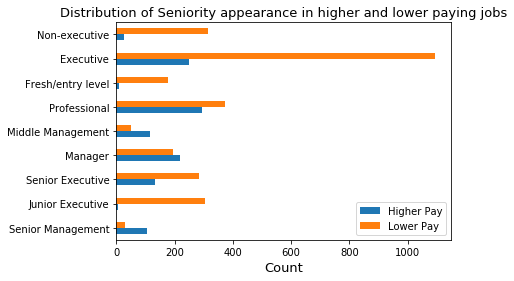

In [350]:
#Plot the to have an idea how how many times each seniority rank appears in either the lower or higher paying category.
plt.figure(figsize=(12,6))
senior_salary.plot(kind='barh')

plt.title('Distribution of Seniority appearance in higher and lower paying jobs', fontsize =13)
plt.xlabel('Count', fontsize=13)

Some seniority descriptions appear far more frequently for either lower paying or higher paying jobs.  

Lower paying jobs:
* Fresh/entry level
* Non-Executive 
* Junior Executive
* Executive 
* Senior Executive

Higher Paying Jobs:
* Senior Management
* Middle Management

Jobs with a relatively similar distribution between both higher and lower paying jobs: 
* Manager
* Professional

In [351]:
#Check the unique entries under employment type
jobs_df_load['EmploymentType'].unique()

array(['Full Time', 'Permanent', 'Contract', 'Permanent, Contract',
       'Contract, Full Time', 'Permanent, Full Time', 'Temporary',
       'Temporary, Contract', 'Contract, Full Time, Flexi work',
       'Part Time, Permanent, Contract, Full Time',
       'Freelance, Full Time, Flexi work',
       'Permanent, Contract, Full Time', 'Internship',
       'Permanent, Temporary, Contract', 'Full Time, Flexi work',
       'Part Time', 'Part Time, Permanent, Full Time',
       'Part Time, Temporary, Contract, Full Time, Flexi work',
       'Temporary, Full Time',
       'Part Time, Permanent, Contract, Freelance, Flexi work',
       'Part Time, Permanent, Freelance, Full Time, Internship',
       'Temporary, Contract, Full Time', 'Permanent, Flexi work',
       'Part Time, Full Time', 'Temporary, Internship',
       'Contract, Internship', 'Permanent, Temporary, Full Time',
       'Part Time, Temporary, Full Time',
       'Permanent, Full Time, Internship',
       'Contract, Full Time, Int

In [352]:
#Create a set to retrieve the unique kinds of employment types
employment = set()
for row in jobs_df_load['EmploymentType'].str.split(','):
    for employ_type in row:
        if employ_type not in employment:
            employment.add(' '.join(employ_type.split()))

In [353]:
#Check what the unique employment types are
employment

{'Contract',
 'Flexi work',
 'Freelance',
 'Full Time',
 'Internship',
 'Part Time',
 'Permanent',
 'Temporary'}

In [354]:
#Turn each seniority rank into a feature
for employ_type in employment:
    jobs_df_load[employ_type]=[1 if employ_type in employment else 0 for employment in jobs_df_load['EmploymentType']]

In [355]:
employment_salary = pd.DataFrame(
                             {'Higher Pay':jobs_df_load[jobs_df_load['HigherPaying']==1][list(employment)].sum(),
                              'Lower Pay':jobs_df_load[jobs_df_load['HigherPaying']==0][list(employment)].sum()},
                                index=list(employment))
employment_salary

Higher Pay  Lower Pay
Flexi work           1          9
Freelance            0          4
Permanent          417        863
Part Time            0         18
Contract           155        421
Internship           2         18
Full Time          611       1322
Temporary            5         29

Text(0.5, 1.0, 'Distribution of employment type in higher and lower paying jobs')

<Figure size 1080x432 with 0 Axes>

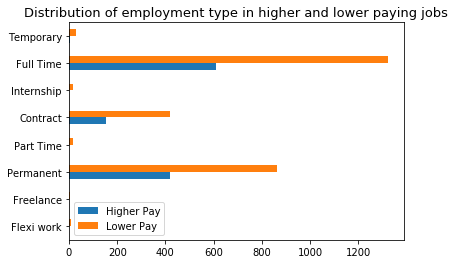

In [356]:
#Plot the to have an idea how how many times each employment appears in either the lower or higher paying category.
plt.figure(figsize=(15,6))
employment_salary.plot(kind='barh')

plt.title('Distribution of employment type in higher and lower paying jobs', fontsize =13)

Unsurprisingly, some of the employment types have few, in any occurances in the higher paying jobs. These employment types are:
* Part Time
* Temporary
* Freelance
* Internship
* Flexi work
* Contract

The employment types that have much more substantial occurances in higher paying jobs are 
* Contract
* Full Time
* Permanent

However, even for contract, full time and permanent posts, they may not be very indicative as, while they occur more frequently in higher paying jobs than the other employment types, they are still predominately occuring in lower paying jobs.

In [357]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

([], <a list of 0 Text yticklabel objects>)

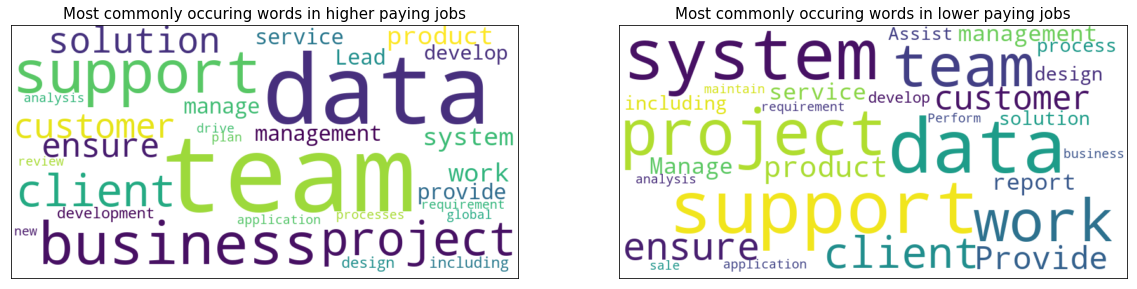

In [358]:
#Take a look at the most commonly occuring words in the job responsibilities

#Separate the text for higher and lower paying jobs
texthigh = ''.join(words for words in jobs_df_load[jobs_df_load['HigherPaying']==1]['Responsibilities'])
textlow = ''.join(words for words in jobs_df_load[jobs_df_load['HigherPaying']==0]['Responsibilities'])

#Generate the words clouds for higher and lower paying jobs
wordcloudhigh=WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(texthigh)
wordcloudlow= WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(textlow)

#Plot the wordclouds
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(wordcloudhigh,interpolation='bilinear')
plt.title('Most commonly occuring words in higher paying jobs',fontsize=15)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(wordcloudlow,interpolation='bilinear')
plt.title('Most commonly occuring words in lower paying jobs',fontsize=15)
plt.xticks([])
plt.yticks([])

Many of the most frequently occurring words for job responsibilities of higher and lower paying jobs are the same, data, support, system, team, project and several others (with slight deviations in rank). 

There doesn't seem to be a clear separation of most frequently occurring words for the job responsibilities between higher and lower paying jobs.

([], <a list of 0 Text yticklabel objects>)

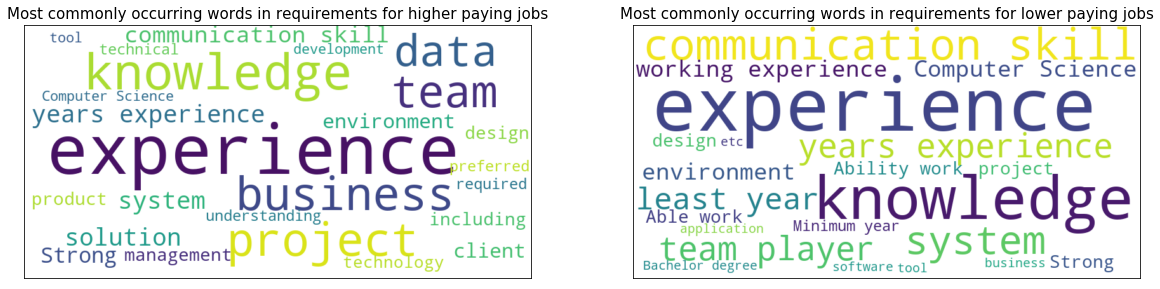

In [359]:
#Take a look at the most commonly occuring words in the job requirements

#Separate the text for higher and lower paying jobs
texthigh = ''.join(words for words in jobs_df_load[jobs_df_load['HigherPaying']==1]['Requirements'])
textlow = ''.join(words for words in jobs_df_load[jobs_df_load['HigherPaying']==0]['Requirements'])

#Generate the words clouds for higher and lower paying jobs
wordcloudhigh=WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(texthigh)
wordcloudlow= WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(textlow)

#Plot the wordclouds
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(wordcloudhigh,interpolation='bilinear')
plt.title('Most commonly occurring words in requirements for higher paying jobs',fontsize=15)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(wordcloudlow,interpolation='bilinear')
plt.title('Most commonly occurring words in requirements for lower paying jobs',fontsize=15)
plt.xticks([])
plt.yticks([])

Words such as experience, knowledge, project, system, communication skill, appear frequently in both higher and lower paying job requirements. There seems to be a greater focus on qualifications for lower paying jobs (words such as Bachelor degree, Computer Science, Ability Work, Able work,) while higher paying jobs seemed to have a greater focus on management (words such as business, client, management, project)  

However, there doesn't seem to be a very strong separation of most frequently occurring words for the job requirements between higher and lower paying jobs.

### 1.6.1 Build a simple model from seniority

In [360]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier

In [361]:
#Split the data into train and test sets
X = jobs_df_load[list(ranks)]
y = jobs_df_load['HigherPaying']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [362]:
#Create a function to compare cross validated results of models
def model_compare(models, X_train, y_train, score):
    scores_dict = {}
    
    for model in models:
        scores = cross_val_score(model,X_train,y_train,cv=10,verbose=1,n_jobs=-1, scoring=score)
        scores_dict[model]=scores
        
    return pd.DataFrame(scores_dict)

In [363]:
#Create a simple Logistic Regression and Random Forest Classifier
logr = LogisticRegression()
rfc = RandomForestClassifier()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


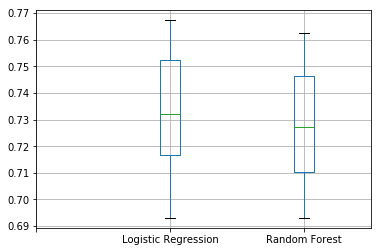

In [364]:
#Create a list of classifiers and run them through cross validation
models = [logr,rfc]
models_summary = model_compare(models, X_train, y_train,'accuracy')

#Plot the distribution of the cross validated accuracy results
models_summary.boxplot()
plt.xticks(np.arange(3),['','Logistic Regression','Random Forest'])
plt.show()

In [365]:
#baseline accuracy:
1-np.mean(y_test)

0.697459584295612

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


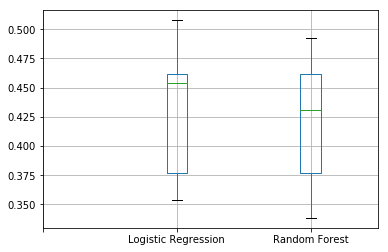

In [366]:
#Create crossvalidate the models and compare the recall scores
models_summary = model_compare(models, X_train, y_train,'recall')

#Plot the distribution of the cross validated accuracy results
models_summary.boxplot()
plt.xticks(np.arange(3),['','Logistic Regression','Random Forest'])
plt.show()

In [367]:
#Create a function to return summary of classification metrics
def class_scorer(estimator,X,y):
    """
    DOCSTRING: Take in the estimator, test set features and target and return confusion matrix and classification report
    INPUT: classification estimator, independent variables, target variable
    OUTPUT: confusion matrix, classification report
    """
    predictions = estimator.predict(X)
    pred_proba = estimator.predict_proba(X)
    print(confusion_matrix(y,predictions))
    print()
    print(classification_report(y,predictions))
    print()
    print('ROC AUC Score: ',roc_auc_score(y,pred_proba[:,1]))

In [368]:
logr=LogisticRegression()
logr.fit(X_train,y_train)
class_scorer(logr, X_test, y_test)

[[544  60]
 [148 114]]

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       604
           1       0.66      0.44      0.52       262

   micro avg       0.76      0.76      0.76       866
   macro avg       0.72      0.67      0.68       866
weighted avg       0.75      0.76      0.74       866


ROC AUC Score:  0.8153562762246601


C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [369]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
class_scorer(rfc, X_test, y_test)

[[544  60]
 [150 112]]

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       604
           1       0.65      0.43      0.52       262

   micro avg       0.76      0.76      0.76       866
   macro avg       0.72      0.66      0.68       866
weighted avg       0.74      0.76      0.74       866


ROC AUC Score:  0.8076405389009655


C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



### 1.6.2 Include the employment type

In [370]:
comb_train = pd.concat([X_train,jobs_df_load.loc[X_train.index][list(employment)]],axis=1)
comb_test = pd.concat([X_test,jobs_df_load.loc[X_test.index][list(employment)]],axis=1)

In [371]:
models_summary = model_compare(models, comb_train, y_train, 'accuracy')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


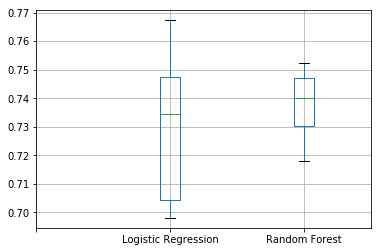

In [372]:
models_summary.boxplot()
plt.xticks(np.arange(3),['','Logistic Regression','Random Forest'])
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


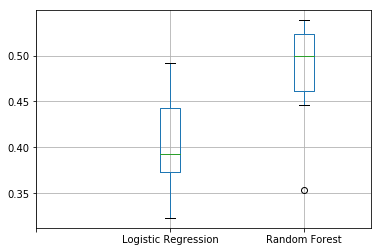

In [373]:
models_summary = model_compare(models, comb_train, y_train, 'recall')
models_summary.boxplot()
plt.xticks(np.arange(3),['','Logistic Regression','Random Forest'])
plt.show()

In [374]:
logr=LogisticRegression()
logr.fit(comb_train,y_train)
class_scorer(logr, comb_test, y_test)

[[548  56]
 [153 109]]

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       604
           1       0.66      0.42      0.51       262

   micro avg       0.76      0.76      0.76       866
   macro avg       0.72      0.66      0.68       866
weighted avg       0.75      0.76      0.74       866


ROC AUC Score:  0.8111287346443558


C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [375]:
rfc = RandomForestClassifier()
rfc.fit(comb_train,y_train)
class_scorer(rfc, comb_test, y_test)

[[516  88]
 [121 141]]

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       604
           1       0.62      0.54      0.57       262

   micro avg       0.76      0.76      0.76       866
   macro avg       0.71      0.70      0.70       866
weighted avg       0.75      0.76      0.75       866


ROC AUC Score:  0.8221146554774783


C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



### 1.6.3 Include responsibilities and requirements

In [376]:
#Create a function to vectorize, split and retrieve feature names for text columns
def text_ttsplit(vectorizer,col):
    '''
    DOCSTRING: This function takes in a vectorizer, and column name to vectorize the text and return the train and test sets and feature names 
    INPUT: a text vectorizer, column name
    OUTPUT: train set, test set, feature names
    '''
    train = vectorizer.fit_transform(jobs_df_load.loc[X_train.index][col])
    test = vectorizer.transform(jobs_df_load.loc[X_test.index][col])
    features = [col+': '+name for name in vectorizer.get_feature_names()]
    
    return train, test, features

In [377]:
#Vectorize and split the responsibilities and requirements columns
cvec = CountVectorizer(ngram_range=(1,2))
resp_train, resp_test, resp_features = text_ttsplit(cvec,'Responsibilities')
req_train, req_test, req_features = text_ttsplit(cvec,'Requirements')

In [378]:
#Merge with the previous set of features
merged_train = hstack([csr_matrix(comb_train),resp_train,req_train])
merged_test = hstack([csr_matrix(comb_test),resp_test,req_test])
merged_features = list(ranks) + list(employment) + resp_features + req_features

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   10.5s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.0s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.8s finished


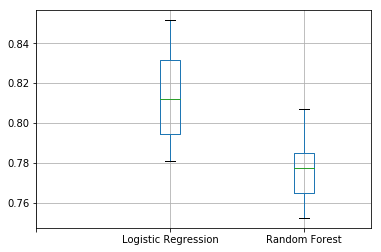

In [379]:
models_summary = model_compare(models, merged_train, y_train, 'accuracy')
models_summary.boxplot()
plt.xticks(np.arange(3),['','Logistic Regression','Random Forest'])
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   10.2s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.7s finished


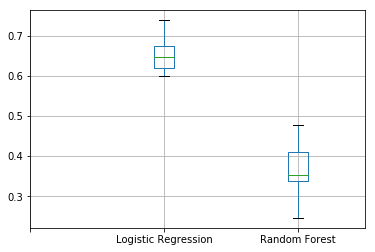

In [380]:
models_summary = model_compare(models, merged_train, y_train, 'recall')
models_summary.boxplot()
plt.xticks(np.arange(3),['','Logistic Regression','Random Forest'])
plt.show()

In [381]:
logr=LogisticRegression()
logr.fit(merged_train,y_train)
class_scorer(logr, merged_test, y_test)

C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



[[526  78]
 [ 84 178]]

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       604
           1       0.70      0.68      0.69       262

   micro avg       0.81      0.81      0.81       866
   macro avg       0.78      0.78      0.78       866
weighted avg       0.81      0.81      0.81       866


ROC AUC Score:  0.8672337091148072


In [382]:
rfc=RandomForestClassifier()
rfc.fit(merged_train,y_train)
class_scorer(rfc, merged_test, y_test)

C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



[[558  46]
 [139 123]]

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       604
           1       0.73      0.47      0.57       262

   micro avg       0.79      0.79      0.79       866
   macro avg       0.76      0.70      0.71       866
weighted avg       0.78      0.79      0.77       866


ROC AUC Score:  0.8220072291592944


In [383]:
def logr_w_grid(X,y):
    """
    DOCSTRING:Gridsearch for Logistic Regression hyperparameters
    INPUT: train set of independent and target variable
    OUTPUT: the model fitted with the best estimator
    """
    
    logr = LogisticRegression()

    logr_params = {
        'penalty':['l1','l2'],
        'C':np.logspace(-3,2,30),
        'solver':['liblinear']
    }

    grid_logr = GridSearchCV(logr,param_grid=logr_params,cv=10,n_jobs=-1,verbose=1)
    grid_logr.fit(X,y)
    
    print(grid_logr.best_score_)
    print(grid_logr.best_params_)
    
    return grid_logr.best_estimator_

In [283]:
optimal_logr = logr_w_grid(merged_train,y_train)
class_scorer(optimal_logr,merged_test,y_test)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  6.2min finished


0.8197127290737989
{'C': 6.2101694189156165, 'penalty': 'l2', 'solver': 'liblinear'}
[[528  76]
 [ 78 184]]

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       604
           1       0.71      0.70      0.70       262

   micro avg       0.82      0.82      0.82       866
   macro avg       0.79      0.79      0.79       866
weighted avg       0.82      0.82      0.82       866


ROC AUC Score:  0.8687124007886355


In [284]:
def rfc_w_grid(X,y):
    rfc = RandomForestClassifier()

    rfc_params = {
        'n_estimators':[300],
        'min_samples_split':range(2,8)
    }

    grid_rfc = GridSearchCV(rfc,param_grid=rfc_params,cv=10,n_jobs=-1,verbose=1)
    grid_rfc.fit(X,y)
    
    print('best score: ', grid_rfc.best_score_)
    print('best parameters: ', grid_rfc.best_params_)
    
    return grid_rfc.best_estimator_

In [95]:
optimal_rfc = rfc_w_grid(merged_train,y_train)
class_scorer(optimal_rfc,merged_test,y_test)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.4min finished


best score:  0.779098563645369
best parameters:  {'min_samples_split': 3, 'n_estimators': 300}
[[565  39]
 [143 119]]

              precision    recall  f1-score   support

           0       0.80      0.94      0.86       604
           1       0.75      0.45      0.57       262

   micro avg       0.79      0.79      0.79       866
   macro avg       0.78      0.69      0.71       866
weighted avg       0.78      0.79      0.77       866


ROC AUC Score:  0.8504056923310247


Try vectorising using Term Frequency, Inverse Document Frequency instead

In [384]:
#Vectorize and split the responsibilities and requirements columns
tfvec = TfidfVectorizer(ngram_range=(1,2))
resp_train, resp_test, resp_features = text_ttsplit(cvec,'Responsibilities')
req_train, req_test, req_features = text_ttsplit(cvec,'Requirements')

In [385]:
#Merge with the previous set of features
merged_train = hstack([csr_matrix(comb_train),resp_train,req_train])
merged_test = hstack([csr_matrix(comb_test),resp_test,req_test])
merged_features = list(ranks) + list(employment) + resp_features + req_features

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   10.4s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.6s finished


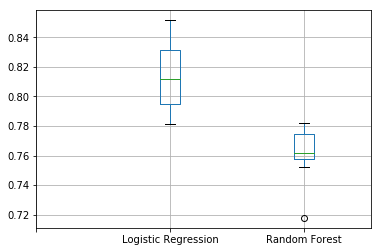

In [386]:
models_summary = model_compare(models, merged_train, y_train, 'accuracy')
models_summary.boxplot()
plt.xticks(np.arange(3),['','Logistic Regression','Random Forest'])
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   10.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.8s finished


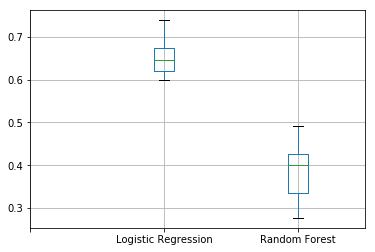

In [387]:
models_summary = model_compare(models, merged_train, y_train, 'recall')
models_summary.boxplot()
plt.xticks(np.arange(3),['','Logistic Regression','Random Forest'])
plt.show()

In [100]:
logr=LogisticRegression()
logr.fit(merged_train,y_train)
class_scorer(logr, merged_test, y_test)

C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



[[526  78]
 [ 84 178]]

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       604
           1       0.70      0.68      0.69       262

   micro avg       0.81      0.81      0.81       866
   macro avg       0.78      0.78      0.78       866
weighted avg       0.81      0.81      0.81       866


ROC AUC Score:  0.8672337091148072


In [101]:
rfc=RandomForestClassifier()
rfc.fit(merged_train,y_train)
class_scorer(rfc, merged_test, y_test)

C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



[[558  46]
 [150 112]]

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       604
           1       0.71      0.43      0.53       262

   micro avg       0.77      0.77      0.77       866
   macro avg       0.75      0.68      0.69       866
weighted avg       0.76      0.77      0.75       866


ROC AUC Score:  0.8080955209544514


From the simple testing above, it seems that CountVectorizer and Logistic Regression gives better results (higher AUC score, better balance between precision and recall)

### 1.6.4 Tune model

In [104]:
def tuner(vec,col1,col2,i,df):
    col1_train, col1_test, col1_features = text_ttsplit(vec,col1)
    col2_train, col2_test, col2_features = text_ttsplit(vec,col2)
   
    merge_train = hstack([csr_matrix(comb_train), col1_train,col2_train])
    merge_test = hstack([csr_matrix(comb_test), col1_test,col2_test])
    merge_features = list(ranks) + list(employment) + col1_features + col2_features
    
    optimal_logr = logr_w_grid(merge_train,y_train)
    predictions = optimal_logr.predict(merge_test)
    predict_prob = optimal_logr.predict_proba(merge_test)
    classification_scores = precision_recall_fscore_support(y_test,predictions)
    confusion_scores = confusion_matrix(y_test,predictions)
    auc_score = roc_auc_score(y_test,predict_prob[:,1])
    
    df.loc[i] = [vec,confusion_scores,
                round(classification_scores[0][0],2),round(classification_scores[0][1],2),
                round(classification_scores[1][0],2),round(classification_scores[1][1],2),
                round(classification_scores[2][0],2),round(classification_scores[2][1],2),
                auc_score]
    
    return df

In [105]:
summary_df = pd.DataFrame({'Vectorizer':[],'Confusion Matrix':[],
                           'NM Precision':[],'M Precision':[],
                           'NM Recall':[],'M Recall':[],
                           'NM F1':[],'M F1':[],
                           'AUC score':[]})

vec_list = [
    CountVectorizer(),
    CountVectorizer(ngram_range=(1,2)),
    CountVectorizer(stop_words='english'),
    CountVectorizer(ngram_range=(1,2),stop_words='english'),
    CountVectorizer(min_df=2),
    CountVectorizer(min_df=5),
    CountVectorizer(max_df=0.99, min_df=2), 
    CountVectorizer(max_df=0.95, min_df=2),
    CountVectorizer(max_df=0.99, min_df=5), 
    CountVectorizer(max_df=0.95, min_df=5),
    CountVectorizer(ngram_range=(1,2),stop_words='english',min_df=2),
    CountVectorizer(ngram_range=(1,2),stop_words='english',min_df=5)
    ]

for i,vector in enumerate(vec_list):
    results_df = tuner(vector,'Responsibilities','Requirements',i,summary_df)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   49.8s finished


0.8147597820703318
{'C': 0.010826367338740546, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  6.2min finished


0.8197127290737989
{'C': 6.2101694189156165, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   40.1s finished


0.8103021297672115
{'C': 0.38566204211634725, 'penalty': 'l1', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.3min finished


0.8226844972758791
{'C': 9.236708571873866, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   45.6s finished


0.8142644873699851
{'C': 0.010826367338740546, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   42.6s finished


0.812778603268945
{'C': 0.010826367338740546, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   47.7s finished


0.8147597820703318
{'C': 0.010826367338740546, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 417 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   46.1s finished


0.8167409608717187
{'C': 0.07880462815669913, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   44.4s finished


0.812778603268945
{'C': 0.010826367338740546, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   42.4s finished


0.8167409608717187
{'C': 0.07880462815669913, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.5min finished


0.8177315502724121
{'C': 0.0529831690628371, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 415 tasks      | elapsed:   18.9s


0.8112927191679049
{'C': 0.02395026619987486, 'penalty': 'l2', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   48.7s finished


In [108]:
#Check the top 5 results
results_df.sort_values('M F1',ascending = False).head(10)

Vectorizer        Confusion Matrix  \
3   CountVectorizer(analyzer='word', binary=False,...  [[535, 69], [78, 184]]   
11  CountVectorizer(analyzer='word', binary=False,...  [[542, 62], [84, 178]]   
1   CountVectorizer(analyzer='word', binary=False,...  [[528, 76], [78, 184]]   
10  CountVectorizer(analyzer='word', binary=False,...  [[537, 67], [83, 179]]   
2   CountVectorizer(analyzer='word', binary=False,...  [[534, 70], [89, 173]]   
0   CountVectorizer(analyzer='word', binary=False,...  [[533, 71], [92, 170]]   
4   CountVectorizer(analyzer='word', binary=False,...  [[533, 71], [91, 171]]   
5   CountVectorizer(analyzer='word', binary=False,...  [[534, 70], [91, 171]]   
6   CountVectorizer(analyzer='word', binary=False,...  [[533, 71], [91, 171]]   
7   CountVectorizer(analyzer='word', binary=False,...  [[524, 80], [86, 176]]   

    NM Precision  M Precision  NM Recall  M Recall  NM F1  M F1  AUC score  
3           0.87         0.73       0.89      0.70   0.88  0.71   0.875449  
11          0.87         0.74       0.90      0.68   0.88  0.71   0.876352  
1           0.87         0.71       0.87      0.70   0.87  0.70   0.868712  
10          0.87         0.73       0.89      0.68   0.88  0.70   0.875885  
2           0.86         0.71       0.88      0.66   0.87  0.69   0.862226  
0           0.85         0.71       0.88      0.65   0.87  0.68   0.876592  
4           0.85         0.71       0.88      0.65   0.87  0.68   0.876498  
5           0.85         0.71       0.88      0.65   0.87  0.68   0.875733  
6           0.85         0.71       0.88      0.65   0.87  0.68   0.876491  
7           0.86         0.69       0.87      0.67   0.86  0.68   0.866848

In [289]:
#Check the vectorize parameters for the top model
vec_list[11]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [393]:
#Vectorize and split the responsibilities and requirements columns
cvec = CountVectorizer(ngram_range=(1,2),stop_words='english')
resp_train_q1, resp_test_q1, resp_features_q1 = text_ttsplit(cvec,'Responsibilities')
req_train_q1, req_test_q1, req_features_q1 = text_ttsplit(cvec,'Requirements')

#Merge with the previous set of features
merged_train_q1 = hstack([csr_matrix(comb_train),resp_train_q1,req_train_q1])
merged_test_q1 = hstack([csr_matrix(comb_test),resp_test_q1,req_test_q1])
merged_features_q1 = list(ranks) + list(employment) + resp_features_q1 + req_features_q1

In [394]:
optimal_logr_q1 = logr_w_grid(merged_train_q1,y_train)
class_scorer(optimal_logr_q1, merged_test_q1, y_test)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.3min finished


0.8226844972758791
{'C': 9.236708571873866, 'penalty': 'l2', 'solver': 'liblinear'}
[[535  69]
 [ 78 184]]

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       604
           1       0.73      0.70      0.71       262

   micro avg       0.83      0.83      0.83       866
   macro avg       0.80      0.79      0.80       866
weighted avg       0.83      0.83      0.83       866


ROC AUC Score:  0.8754486628582985


In [398]:
feats_df = pd.DataFrame({'Features':merged_features_q1,'coef':optimal_logr_q1.coef_[0],'abs coef':abs(optimal_logr_q1.coef_[0])})
feats_df.sort_values('abs coef', ascending = False).head(10)

Features      coef  abs coef
7                              Executive -4.139601  4.139601
4                      Middle Management  3.699470  3.699470
1                       Junior Executive -2.254724  2.254724
239219            Requirements: sql plus -1.852435  1.852435
168632              Requirements: 3years -1.489138  1.489138
90057   Responsibilities: manager senior -1.455972  1.455972
11                             Permanent  1.297032  1.297032
2                       Senior Executive  1.162974  1.162974
223384                Requirements: plus -1.145066  1.145066
6                      Fresh/entry level -1.089155  1.089155

In [399]:
feats_df.sort_values('coef', ascending = False).head(10)

Features      coef  abs coef
4                      Middle Management  3.699470  3.699470
11                             Permanent  1.297032  1.297032
2                       Senior Executive  1.162974  1.162974
168719                 Requirements: 5or  1.035303  1.035303
178369      Requirements: candidates 5or  1.035303  1.035303
168720           Requirements: 5or years  1.035303  1.035303
182088             Requirements: company  0.810607  0.810607
168844              Requirements: 8years  0.800937  0.800937
168845   Requirements: 8years experience  0.798530  0.798530
192731  Requirements: engineering 8years  0.798530  0.798530

In [424]:
feats_df.sort_values('coef', ascending = True).head(10)

Features      coef  abs coef
7                              Executive -4.139601  4.139601
1                       Junior Executive -2.254724  2.254724
239219            Requirements: sql plus -1.852435  1.852435
168632              Requirements: 3years -1.489138  1.489138
90057   Responsibilities: manager senior -1.455972  1.455972
223384                Requirements: plus -1.145066  1.145066
6                      Fresh/entry level -1.089155  1.089155
178451    Requirements: candidates years -1.028573  1.028573
5                           Professional -0.876344  0.876344
8                          Non-executive -0.818602  0.818602

In [431]:
feats_df[feats_df['Features'].str.contains('Requirements')].sort_values('coef', ascending = False).head(15)

Features      coef  abs coef
168720            Requirements: 5or years  1.035303  1.035303
168719                  Requirements: 5or  1.035303  1.035303
178369       Requirements: candidates 5or  1.035303  1.035303
182088              Requirements: company  0.810607  0.810607
168844               Requirements: 8years  0.800937  0.800937
192731   Requirements: engineering 8years  0.798530  0.798530
168845    Requirements: 8years experience  0.798530  0.798530
197905         Requirements: field 6years  0.706152  0.706152
168795            Requirements: 6years ms  0.706152  0.706152
168793               Requirements: 6years  0.705807  0.705807
168721               Requirements: 5years  0.585839  0.585839
198078       Requirements: fields minimum  0.574257  0.574257
228329         Requirements: python excel  0.544714  0.544714
202615        Requirements: holder 5years  0.544714  0.544714
168727  Requirements: 5years professional  0.544714  0.544714

In [432]:
feats_df[feats_df['Features'].str.contains('Requirements')].sort_values('coef', ascending = True).head(15)

Features      coef  abs coef
239219              Requirements: sql plus -1.852435  1.852435
168632                Requirements: 3years -1.489138  1.489138
223384                  Requirements: plus -1.145066  1.145066
178451      Requirements: candidates years -1.028573  1.028573
168634     Requirements: 3years experience -0.792218  0.792218
192729    Requirements: engineering 3years -0.788591  0.788591
197903          Requirements: field 3years -0.695880  0.695880
168635             Requirements: 3years ms -0.695880  0.695880
178367            Requirements: candidates -0.547417  0.547417
202639          Requirements: holder years -0.508226  0.508226
251194    Requirements: years professional -0.505227  0.505227
228412  Requirements: python understanding -0.494612  0.494612
170926             Requirements: advantage -0.483936  0.483936
249649                 Requirements: with3 -0.482717  0.482717
192925     Requirements: engineering with3 -0.482717  0.482717

__Q1 Summary:__  
In this section, I looked at what factors impact job salary. The objective is to see what determines a higher paying job.

Data was obtained from scrapping https://www.mycareersfuture.sg/, where I was able to retrieve over 4000 job postings. From the over 4000 job postings, I removed incomplete data and further filtered the number down by reducing jobs that were less related to data science and analytics, eventually moving forward with about 2800 job postings. Some of the data, such as the text fields and salary obtained, had to be cleaned before visualisation and modelling.

From the exploratory data analysis, the threshold for higher paying jobs was defined as a minimum monthly salary of $6000, which was the 75 percentile of the jobs scrapped. It was also observed that Senior and Middle Management roles occurred more often in higher paying jobs. None of the employment types (permanent/part-time) seemed indicative of higher or lower paying jobs and when looking at the most commonly occuring words for both responsibilities and requirements, there was no clear distinction between higher and lower paying jobs. 

I explored both Logistic Regression and Random Forest models. The text fields for job requirements and job responsibilities were vectorized for text processing through a few different means. After trying several models and hyperparameters, I settled on using the count vectorization to transform the text fields before running a Logistic Regression, as that gave the best F1 score, balancing between both precision and accuracy. It also had the advantange of greater interpretability, allowing for insight into the significant factors in identifying a higher paying job.

__What are the key factors that separate higher and lower paying jobs?__  
* Seniority  
* Experience  
* Skills  

Most indicative factors were related to more seniority, job postings offering positions as Middle Managers and an Senior Executives were more likely to be higher paying jobs while job postings offering positions as  Executives and Junior Executives were more likely to be lower paying jobs. Permanent employment was also more likely to point to higher paying jobs.

Responsibilities did not seem to play a significant role in determining higher and lower paying jobs, but requirements were featured heavily. A requirement of 5 to 8 years of work experience was often indicative of higher paying jobs, as well as skills in Python and Excel. On the other hand, about 3 years of experience and skills such as SQL were more indicative of lower paying jobs.

__Conclusion__   
To connect more applicants to land higher paying data related jobs, our company would need to look for applicants with greater years of experience, skills in Python and Excel. We would also have to be on the lookout for contracts for managerial and senior positions, as well as those offering permanent employment.

## Bonus Problem (Q3):
Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

In [403]:
#Take a look a the confusion matrix from the original model from question 1
def show_matrix(y_true,y_pred):
    con_matrix = pd.DataFrame(data = confusion_matrix(y_true, y_pred), 
                                 index = ['Lower Paying','Higher Paying'],
                                 columns = ['Pred Lower Paying','Pred Higher Paying'])
    return con_matrix

In [405]:
show_matrix(y_test,optimal_logr_q1.predict(merged_test_q1))

Pred Lower Paying  Pred Higher Paying
Lower Paying                 535                  69
Higher Paying                 78                 184

The classification model generates a probability that each entry belongs to either class and if the threshold for deciding which class it belongs to is 0.5. If we want to reduce the number of false positives (a flase positive is predicting a higher paying job when it is actually lower paying), we can raise the threshold to only predict higher paying jobs when hte model is even more certain. 

In [409]:
#Creating the predicted classes for different thresholds
thresh_sixty = [1 if proba > 0.6 else 0 for proba in optimal_logr_q1.predict_proba(merged_test_q1)[:,1]]
thresh_seventy = [1 if proba > 0.7 else 0 for proba in optimal_logr_q1.predict_proba(merged_test_q1)[:,1]]
thresh_eighty = [1 if proba > 0.8 else 0 for proba in optimal_logr_q1.predict_proba(merged_test_q1)[:,1]]
thresh_ninety = [1 if proba > 0.9 else 0 for proba in optimal_logr_q1.predict_proba(merged_test_q1)[:,1]]

In [410]:
show_matrix(y_test,thresh_sixty)

Pred Lower Paying  Pred Higher Paying
Lower Paying                 538                  66
Higher Paying                 82                 180

In [411]:
show_matrix(y_test,thresh_seventy)

Pred Lower Paying  Pred Higher Paying
Lower Paying                 544                  60
Higher Paying                 86                 176

In [412]:
show_matrix(y_test,thresh_eighty)

Pred Lower Paying  Pred Higher Paying
Lower Paying                 549                  55
Higher Paying                 97                 165

In [413]:
show_matrix(y_test,thresh_ninety)

Pred Lower Paying  Pred Higher Paying
Lower Paying                 555                  49
Higher Paying                108                 154

As can be seen, by raising the threshold, the number of false positives declines. However, so does the number of true positives and at the same time, the number of false negatives is rising.

Another way to visualise this is to look at the Receiver Operating Characteristic (ROC) curve to get an better picture of this trade-off between true and false positives.

In [414]:
from sklearn.metrics import roc_curve, auc

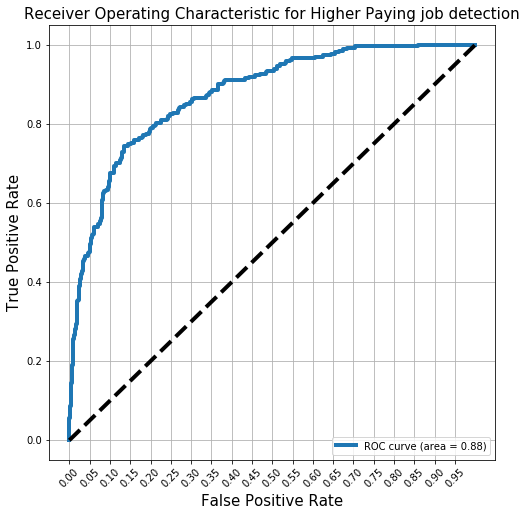

In [415]:
predprob_q1 = optimal_logr_q1.predict_proba(merged_test_q1)

fpr, tpr, thresholds = roc_curve(y_test, predprob_q1[:,1])
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth =4)
plt.plot([0,1],[0,1], 'k--', linewidth=4)

plt.xlim([-0.05,1.0])
plt.xlim([-0.05,1.05])
plt.xticks(np.arange(0,1,0.05),rotation = 45)
plt.grid()

plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver Operating Characteristic for Higher Paying job detection', fontsize=15)
plt.legend(loc='lower right')


In [416]:
df = pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':thresholds})

In [420]:
df[(df['threshold']>=0.5) & (df['threshold']<=0.55)].sort_values('threshold')

fpr       tpr  threshold
106  0.114238  0.702290   0.509424
105  0.114238  0.694656   0.520272
104  0.110927  0.694656   0.523690

In [421]:
df[(df['fpr']>=0.09) & (df['fpr']<=0.10)].sort_values('fpr')

fpr       tpr  threshold
91  0.091060  0.629771   0.803532
92  0.091060  0.633588   0.796353
93  0.096026  0.633588   0.786785
94  0.096026  0.641221   0.768609
95  0.097682  0.641221   0.764549
96  0.097682  0.656489   0.714692
97  0.099338  0.656489   0.711354
98  0.099338  0.671756   0.705126

In [422]:
show_matrix(y_test,optimal_logr_q1.predict(merged_test_q1))

Pred Lower Paying  Pred Higher Paying
Lower Paying                 535                  69
Higher Paying                 78                 184

In [419]:
show_matrix(y_test,thresh_eighty)

Pred Lower Paying  Pred Higher Paying
Lower Paying                 549                  55
Higher Paying                 97                 165

### The ROC curve depicts the corresponding True and False positive rates for various thresholds. 

From the curve, if we wanted a situation where we were able to pick up every actualy higher paying job (True Positive Rate of 1), we would have a False Positive Rate of about 0.7. We want to lower the false positive rate but it comes at the cost of our True Positive Rate. 

From a business perspective, that would mean that would be fewer cases of telling clients incorrectly that they would be getting a higher paying job when it is actually lower paying, we will likely lose potential contracts on higher paying jobs as we inform clients that the jobs are lower paying ones.

Looking at the curve, at a False Positive Rate of about 0.15, the gain in True Positive Rate beyond that point (as observed by the gradient) starts to drop significantly. However, since at the current threshold we are already at a False Positive Rate of 0.11, to further reduce the False Positive Rate, we can lower it to about 0.09, which would be a threshold of about 0.8. By increasing the threshold to 0.8, there would have been 14 fewer False Positive cases for the test set, or about a 20% reduction of such cases. 

# Question 2: Exploring the factors that distinguish managerial jobs from non-managerial jobs

## 2.1 EDA 

In [145]:
#Create a new target column of Managerial Roles
jobs_df_load['ManagerialRole']=[1 if jobs_df_load.loc[index][['Manager','Middle Management','Senior Management']].sum() >=1 else 0 for index in jobs_df_load.index]

In [146]:
#Check the counts of each class
jobs_df_load['ManagerialRole'].value_counts()

0    2218
1     667
Name: ManagerialRole, dtype: int64

In [147]:
#Check proportion for each class
jobs_df_load['ManagerialRole'].value_counts()/len(jobs_df_load)

0    0.768804
1    0.231196
Name: ManagerialRole, dtype: float64

([], <a list of 0 Text yticklabel objects>)

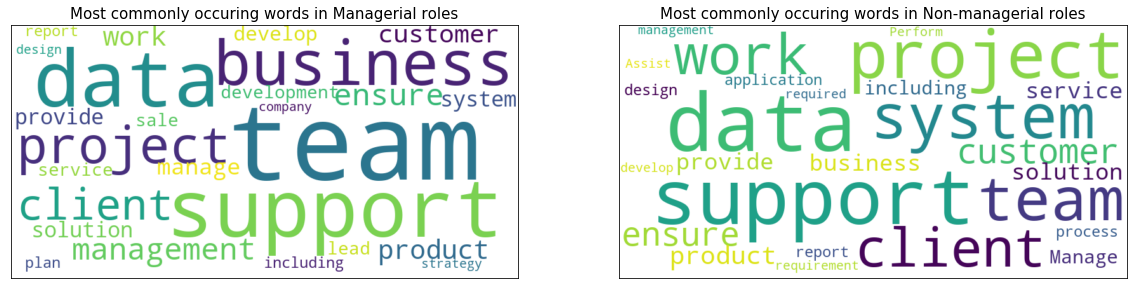

In [148]:
#Take a look at the most commonly occuring words in the job responsibilities

#Separate the text for higher and lower paying jobs
texthigh = ''.join(words for words in jobs_df_load[jobs_df_load['ManagerialRole']==1]['Responsibilities'])
textlow = ''.join(words for words in jobs_df_load[jobs_df_load['ManagerialRole']==0]['Responsibilities'])

#Generate the words clouds for higher and lower paying jobs
wordcloudhigh=WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(texthigh)
wordcloudlow= WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(textlow)

#Plot the wordclouds
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(wordcloudhigh,interpolation='bilinear')
plt.title('Most commonly occuring words in Managerial roles',fontsize=15)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(wordcloudlow,interpolation='bilinear')
plt.title('Most commonly occuring words in Non-managerial roles',fontsize=15)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

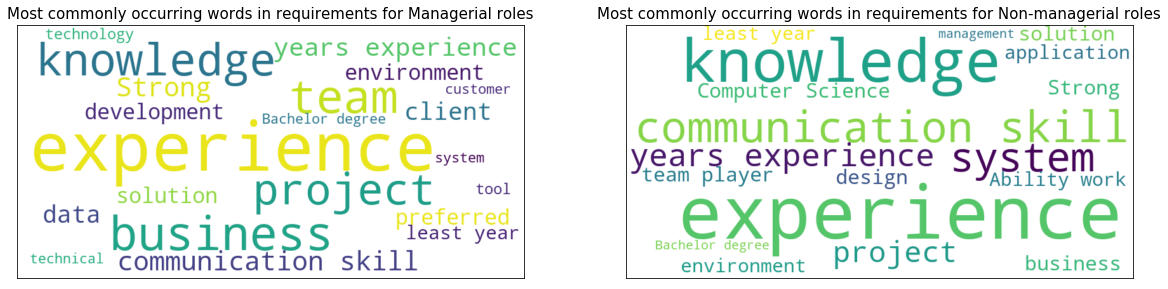

In [149]:
#Take a look at the most commonly occuring words in the job requirements

#Separate the text for higher and lower paying jobs
texthigh = ''.join(words for words in jobs_df_load[jobs_df_load['ManagerialRole']==1]['Requirements'])
textlow = ''.join(words for words in jobs_df_load[jobs_df_load['ManagerialRole']==0]['Requirements'])

#Generate the words clouds for higher and lower paying jobs
wordcloudhigh=WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(texthigh)
wordcloudlow= WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(textlow)

#Plot the wordclouds
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(wordcloudhigh,interpolation='bilinear')
plt.title('Most commonly occurring words in requirements for Managerial roles',fontsize=15)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(wordcloudlow,interpolation='bilinear')
plt.title('Most commonly occurring words in requirements for Non-managerial roles',fontsize=15)
plt.xticks([])
plt.yticks([])

### 2.2.1 Start a simple model using only responsibilities

In [150]:
X = jobs_df_load['Responsibilities']
y = jobs_df_load['ManagerialRole']

In [253]:
#Split dataset into train and test, seed the random state so results are repeatable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [152]:
#Vectorize and split the responsibilities column
cvec = CountVectorizer(ngram_range=(1,2))
resp_train, resp_test, resp_features = text_ttsplit(cvec,'Responsibilities')

In [153]:
#Cross validate a simple Logistic Regression
logr = LogisticRegression()
scores = cross_val_score(logr,resp_train,y_train,cv=10,verbose=1,n_jobs=-1)
print('Mean score: ',np.mean(scores))
print('Scores std: ',np.std(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.6s remaining:    2.3s


Mean score:  0.830601940791094
Scores std:  0.01816645136651624


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


In [255]:
#Baseline
1-np.mean(y_test)

0.7840646651270208

In [154]:
#Fit the full training set and run the model on the test set
logr.fit(resp_train,y_train)
class_scorer(logr, resp_test, y_test)

C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



[[626  53]
 [ 92  95]]

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       679
           1       0.64      0.51      0.57       187

   micro avg       0.83      0.83      0.83       866
   macro avg       0.76      0.71      0.73       866
weighted avg       0.82      0.83      0.83       866


ROC AUC Score:  0.8101998062580233


In [155]:
#Cross validate a simple Random Forest Classifier
rfc = RandomForestClassifier()
scores = cross_val_score(rfc,resp_train,y_train,cv=10,verbose=1,n_jobs=-1)
print('Mean score: ',np.mean(scores))
print('Scores std: ',np.std(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.2s remaining:    2.1s


Mean score:  0.8048495148022266
Scores std:  0.014269984104983738


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


In [156]:
#Fit the full training set and run the model on the test set
rfc.fit(resp_train,y_train)
class_scorer(rfc, resp_test, y_test)

C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



[[662  17]
 [134  53]]

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       679
           1       0.76      0.28      0.41       187

   micro avg       0.83      0.83      0.83       866
   macro avg       0.79      0.63      0.66       866
weighted avg       0.82      0.83      0.79       866


ROC AUC Score:  0.7726997078118969


Random Forest works better for precision but really poor for recall.

### 2.2.2 Include requirements and see if there is any significant difference

In [157]:
#Vectorize and split the requirements column
cvec = CountVectorizer(ngram_range=(1,2))
req_train, req_test, req_features = text_ttsplit(cvec,'Requirements')

In [158]:
#combine the responsibilities and requirement matrices and features
comb_train = hstack([resp_train,req_train])
comb_test = hstack([resp_test,req_test])
comb_features = resp_features + req_features

In [159]:
#Cross validate a simple Logistic Regression
logr = LogisticRegression()
scores = cross_val_score(logr,comb_train,y_train,cv=10,verbose=1,n_jobs=-1)
print('Mean score: ',np.mean(scores))
print('Scores std: ',np.std(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   10.2s remaining:    6.8s


Mean score:  0.8325895276094775
Scores std:  0.02245219592110443


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.4s finished


In [256]:
#Fit the full training set and run the model on the test set
logr.fit(comb_train,y_train)
class_scorer(logr, comb_test, y_test)

C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



[[659  20]
 [121  66]]

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       679
           1       0.77      0.35      0.48       187

   micro avg       0.84      0.84      0.84       866
   macro avg       0.81      0.66      0.69       866
weighted avg       0.83      0.84      0.81       866


ROC AUC Score:  0.8715435565041386


In [161]:
#Cross validate a simple Random Forest Classifier
rfc = RandomForestClassifier()
scores = cross_val_score(rfc,resp_train,y_train,cv=10,verbose=1,n_jobs=-1)
print('Mean score: ',np.mean(scores))
print('Scores std: ',np.std(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.9s remaining:    1.9s


Mean score:  0.8013841682675732
Scores std:  0.0193832340429689


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


In [162]:
#Fit the full training set and run the model on the test set
rfc.fit(comb_train,y_train)
class_scorer(rfc, comb_test, y_test)

C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



[[664  15]
 [134  53]]

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       679
           1       0.78      0.28      0.42       187

   micro avg       0.83      0.83      0.83       866
   macro avg       0.81      0.63      0.66       866
weighted avg       0.82      0.83      0.79       866


ROC AUC Score:  0.7815559213376072


The scores for both Logistic Regression and Random Forest saw a slight improvement after including the information from the job requirements. Logistic Regression balances between false positives and negatives better while the Random Forest performs better at false positives (lower false positives) but much worse for false negatives.
Better results should be achievable from tuning the models' hyperparameters and vectorizing the text in other ways.

In [163]:
#Take a look at the significant features from the logistic regression
results_df = pd.DataFrame({'Features':comb_features,'coef':logr.coef_[0],'abs coef':abs(logr.coef_[0])})
results_df.sort_values('abs coef', ascending = False).head(15)

Features      coef  abs coef
162968                  Requirements: 10  0.419540  0.419540
85833          Responsibilities: manager  0.399509  0.399509
173351                 Requirements: b31 -0.388195  0.388195
47352           Responsibilities: duties -0.379571  0.379571
186239             Requirements: diploma -0.370825  0.370825
3763    Responsibilities: administrative -0.354080  0.354080
133954           Responsibilities: space  0.343016  0.343016
114402        Responsibilities: projects  0.339353  0.339353
84984           Responsibilities: manage  0.338669  0.338669
209700           Requirements: master of -0.335945  0.335945
206136          Requirements: leadership  0.330218  0.330218
147813         Responsibilities: through  0.325633  0.325633
220553              Requirements: phd of  0.325313  0.325313
217511              Requirements: or phd  0.314468  0.314468
11880      Responsibilities: and support  0.313699  0.313699

In [164]:
#Top positively related words for responsibilities for managerial roles
results_df[results_df['Features'].str.contains('Responsibilities: ')].sort_values('coef', ascending = False).head(8)

Features      coef  abs coef
85833       Responsibilities: manager  0.399509  0.399509
133954        Responsibilities: space  0.343016  0.343016
114402     Responsibilities: projects  0.339353  0.339353
84984        Responsibilities: manage  0.338669  0.338669
147813      Responsibilities: through  0.325633  0.325633
11880   Responsibilities: and support  0.313699  0.313699
103634      Responsibilities: oversee  0.294624  0.294624
43553   Responsibilities: development  0.264860  0.264860

In [165]:
#Top positively related words for requirements for managerial roles
results_df[results_df['Features'].str.contains('Requirements: ')].sort_values('coef', ascending = False).head(8)

Features      coef  abs coef
162968              Requirements: 10  0.419540  0.419540
206136      Requirements: leadership  0.330218  0.330218
220553          Requirements: phd of  0.325313  0.325313
217511          Requirements: or phd  0.314468  0.314468
208528      Requirements: management  0.301983  0.301983
209701       Requirements: master or  0.297793  0.297793
247461         Requirements: with 10  0.296457  0.296457
211301  Requirements: minimum5 years  0.294278  0.294278

In [166]:
#Top negatively related words for responsibilities for managerial roles
results_df[results_df['Features'].str.contains('Responsibilities: ')].sort_values('coef', ascending = True).head(8)

Features      coef  abs coef
47352           Responsibilities: duties -0.379571  0.379571
3763    Responsibilities: administrative -0.354080  0.354080
63178           Responsibilities: global -0.302457  0.302457
155050           Responsibilities: users -0.297831  0.297831
83994         Responsibilities: maintain -0.294880  0.294880
7339           Responsibilities: analyst -0.291703  0.291703
13339      Responsibilities: application -0.288265  0.288265
90717           Responsibilities: models -0.268885  0.268885

In [167]:
#Top positively related words for requirements for managerial roles
results_df[results_df['Features'].str.contains('Requirements: ')].sort_values('coef', ascending = True).head(12)

Features      coef  abs coef
173351              Requirements: b31 -0.388195  0.388195
186239          Requirements: diploma -0.370825  0.370825
209700        Requirements: master of -0.335945  0.335945
206587      Requirements: least years -0.304535  0.304535
206589      Requirements: least1 year -0.298627  0.298627
206588           Requirements: least1 -0.298627  0.298627
172518        Requirements: at least1 -0.298627  0.298627
211299   Requirements: minimum3 years -0.295295  0.295295
211298         Requirements: minimum3 -0.295295  0.295295
204040  Requirements: issues minimum3 -0.290432  0.290432
213578               Requirements: no -0.265161  0.265161
166735         Requirements: analysis -0.262707  0.262707

Looking at the feature coefficients from the Logistic Regression model, responsibilities for managerial roles are more related to managing, overseeing, supporting and developing while responsibilities for non managrial roles are more related to analysis, modelling, maintaining, application, users, administration and duties. 

In terms of the requirements, for managerial positions the most related terms are 5 or 10 years experience, leadership or management skills, PhD or Masters. For non-managerial positions, requirements that are more related are 1 to 3 years of experience, a diploma, and analysis skills.

### 2.2.3 Try TfidfVectorizer on both responsibilities and requirements

In [169]:
#Vectorize and split the responsibilities and requirements columns
tfvec = TfidfVectorizer(ngram_range=(1,2))
resp_train, resp_test, resp_features = text_ttsplit(tfvec,'Responsibilities')
req_train, req_test, req_features = text_ttsplit(tfvec,'Requirements')

#combine the responsibilities and requirement matrices and features
comb_train = hstack([resp_train,req_train])
comb_test = hstack([resp_test,req_test])
comb_features = resp_features + req_features

In [170]:
#Cross validate a simple Logistic Regression
logr = LogisticRegression()
scores = cross_val_score(logr,comb_train,y_train,cv=10,verbose=1,n_jobs=-1)
print('Mean score: ',np.mean(scores))
print('Scores std: ',np.std(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.5s remaining:    1.0s


Mean score:  0.799906408551303
Scores std:  0.015300530282442033


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished


In [171]:
#Fit the full training set and run the model on the test set
logr.fit(comb_train,y_train)
class_scorer(logr, comb_test, y_test)

C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



[[660  19]
 [125  62]]

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       679
           1       0.77      0.33      0.46       187

   micro avg       0.83      0.83      0.83       866
   macro avg       0.80      0.65      0.68       866
weighted avg       0.82      0.83      0.81       866


ROC AUC Score:  0.8685586699534548


In [172]:
#Cross validate a simple Random Forest Classifier
rfc = RandomForestClassifier()
scores = cross_val_score(rfc,resp_train,y_train,cv=10,verbose=1,n_jobs=-1)
print('Mean score: ',np.mean(scores))
print('Scores std: ',np.std(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.8s remaining:    1.8s


Mean score:  0.8023718043446136
Scores std:  0.016255190630153238


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


In [173]:
#Fit the full training set and run the model on the test set
rfc.fit(comb_train,y_train)
class_scorer(rfc, comb_test, y_test)

C:\Users\kwanw\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



[[662  17]
 [137  50]]

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       679
           1       0.75      0.27      0.39       187

   micro avg       0.82      0.82      0.82       866
   macro avg       0.79      0.62      0.64       866
weighted avg       0.81      0.82      0.79       866


ROC AUC Score:  0.7839265040599184


### 2.2.4 Tuning model parameters and text vectorizers

In [183]:
summary_df_q2 = pd.DataFrame({'Vectorizer':[],'Confusion Matrix':[],
                           'NM Precision':[],'M Precision':[],
                           'NM Recall':[],'M Recall':[],
                           'NM F1':[],'M F1':[],
                           'AUC score':[]})

vec_list_q2 = [
    TfidfVectorizer(),
    TfidfVectorizer(ngram_range=(1,2)),
    TfidfVectorizer(stop_words='english'),
    TfidfVectorizer(ngram_range=(1,2),stop_words='english'),
    TfidfVectorizer(min_df=2),
    TfidfVectorizer(min_df=5),
    TfidfVectorizer(max_df=0.99, min_df=2), 
    TfidfVectorizer(max_df=0.95, min_df=2),
    TfidfVectorizer(max_df=0.99, min_df=5), 
    TfidfVectorizer(max_df=0.95, min_df=5),
    TfidfVectorizer(ngram_range=(1,2),stop_words='english',min_df=2),
    TfidfVectorizer(ngram_range=(1,2),stop_words='english',min_df=5)
    ]

for i,vector in enumerate(vec_list_q2):
    results_df_q2 = tuner(vector,'Responsibilities','Requirements',i,summary_df)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.1min finished


0.8380386329866271
{'C': 67.23357536499334, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.8min finished


0.8380386329866271
{'C': 45.2035365636025, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.0min finished


0.836552748885587
{'C': 45.2035365636025, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.5min finished


0.8390292223873205
{'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.0min finished


0.8370480435859337
{'C': 45.2035365636025, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.9min finished


0.8370480435859337
{'C': 13.738237958832638, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.0min finished


0.8380386329866271
{'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.0min finished


0.8385339276869738
{'C': 67.23357536499334, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.9min finished


0.8380386329866271
{'C': 30.39195382313201, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.9min finished


0.8380386329866271
{'C': 30.39195382313201, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.5min finished


0.8424962852897474
{'C': 67.23357536499334, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.0min finished


0.8390292223873205
{'C': 4.175318936560405, 'penalty': 'l2', 'solver': 'liblinear'}


In [212]:
results_df_q2.sort_values('M F1', ascending=False).head(10)

Vectorizer        Confusion Matrix  \
3   TfidfVectorizer(analyzer='word', binary=False,...  [[638, 41], [77, 110]]   
4   TfidfVectorizer(analyzer='word', binary=False,...  [[639, 40], [78, 109]]   
10  TfidfVectorizer(analyzer='word', binary=False,...  [[640, 39], [78, 109]]   
0   TfidfVectorizer(analyzer='word', binary=False,...  [[637, 42], [79, 108]]   
1   TfidfVectorizer(analyzer='word', binary=False,...  [[639, 40], [80, 107]]   
6   TfidfVectorizer(analyzer='word', binary=False,...  [[638, 41], [79, 108]]   
7   TfidfVectorizer(analyzer='word', binary=False,...  [[637, 42], [79, 108]]   
2   TfidfVectorizer(analyzer='word', binary=False,...  [[637, 42], [82, 105]]   
5   TfidfVectorizer(analyzer='word', binary=False,...  [[638, 41], [82, 105]]   
8   TfidfVectorizer(analyzer='word', binary=False,...  [[638, 41], [81, 106]]   

    NM Precision  M Precision  NM Recall  M Recall  NM F1  M F1  AUC score  
3           0.89         0.73       0.94      0.59   0.92  0.65   0.868425  
4           0.89         0.73       0.94      0.58   0.92  0.65   0.865030  
10          0.89         0.74       0.94      0.58   0.92  0.65   0.867929  
0           0.89         0.72       0.94      0.58   0.91  0.64   0.864392  
1           0.89         0.73       0.94      0.57   0.91  0.64   0.866952  
6           0.89         0.72       0.94      0.58   0.91  0.64   0.862841  
7           0.89         0.72       0.94      0.58   0.91  0.64   0.863416  
2           0.89         0.71       0.94      0.56   0.91  0.63   0.867551  
5           0.89         0.72       0.94      0.56   0.91  0.63   0.867684  
8           0.89         0.72       0.94      0.57   0.91  0.63   0.864707

In [185]:
#save the results
results_df_q2.to_csv('vector_comparison_a2.csv')

In [213]:
#Check the parameters
results_df_q2.loc[3]['Vectorizer']

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [215]:
#Vectorize and split the requirements column
tfvec = TfidfVectorizer(ngram_range=(1,2),stop_words='english')
req_train, req_test, req_features = text_ttsplit(tfvec,'Requirements')
resp_train, resp_test, resp_features = text_ttsplit(tfvec,'Responsibilities')

#combine the responsibilities and requirement matrices and features
comb_train = hstack([resp_train,req_train])
comb_test = hstack([resp_test,req_test])
comb_features = resp_features + req_features

In [216]:
optimal_logr = logr_w_grid(comb_train,y_train)
class_scorer(optimal_logr,comb_test,y_test)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.4min finished


0.8355621594848935
{'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}
[[635  44]
 [ 76 111]]

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       679
           1       0.72      0.59      0.65       187

   micro avg       0.86      0.86      0.86       866
   macro avg       0.80      0.76      0.78       866
weighted avg       0.85      0.86      0.86       866


ROC AUC Score:  0.870385830058359


In [217]:
#Create a DataFrame of the features and their coefficients
feats_df = pd.DataFrame({'Features':comb_features,'coef':optimal_logr.coef_[0],'abs coef':abs(optimal_logr.coef_[0])})

In [218]:
feats_df[feats_df['Features'].str.contains('Requirements')].sort_values('coef',ascending=False).head(8)

Features      coef  abs coef
168126              Requirements: 10  5.813661  5.813661
168151        Requirements: 10 years  5.107976  5.107976
212627      Requirements: management  4.759886  4.759886
209890      Requirements: leadership  4.565827  4.565827
177643        Requirements: business  4.140254  4.140254
227230         Requirements: project  3.786801  3.786801
192709  Requirements: engineering 10  3.775118  3.775118
213994      Requirements: master phd  3.700196  3.700196

In [219]:
feats_df[feats_df['Features'].str.contains('Requirements')].sort_values('coef',ascending=True).head(10)

Features      coef  abs coef
175550                 Requirements: b31 -4.561736  4.561736
213981     Requirements: master computer -4.130926  4.130926
189633             Requirements: diploma -3.317639  3.317639
210352              Requirements: least1 -2.902466  2.902466
189989  Requirements: disciplines least1 -2.902466  2.902466
210353         Requirements: least1 year -2.902466  2.902466
234910            Requirements: security -2.615292  2.615292
183977   Requirements: contract duration -2.614755  2.614755
181411  Requirements: comfortable months -2.561265  2.561265
216481     Requirements: months contract -2.538273  2.538273

In [220]:
feats_df[feats_df['Features'].str.contains('Responsibilities')].sort_values('coef',ascending=False).head(8)

Features      coef  abs coef
89800       Responsibilities: manager  4.809629  4.809629
88583        Responsibilities: manage  4.767403  4.767403
45060       Responsibilities: digital  4.276970  4.276970
19013      Responsibilities: business  3.921456  3.921456
104661      Responsibilities: oversee  3.779997  3.779997
82742          Responsibilities: lead  3.755297  3.755297
43949   Responsibilities: development  3.674938  3.674938
89052    Responsibilities: management  3.663889  3.663889

In [221]:
feats_df[feats_df['Features'].str.contains('Responsibilities')].sort_values('coef',ascending=True).head(8)

Features      coef  abs coef
65766           Responsibilities: google -2.918216  2.918216
161781           Responsibilities: users -2.789230  2.789230
167233           Responsibilities: world -2.688719  2.688719
95719           Responsibilities: models -2.611450  2.611450
48411           Responsibilities: duties -2.555794  2.555794
4649    Responsibilities: administrative -2.509230  2.509230
7902           Responsibilities: analyst -2.504085  2.504085
12676           Responsibilities: assist -2.441764  2.441764

The key terms for both responsibilities and requirements are very similar to the initial models. For managerial roles, the terms that are most related to responsibilities are regarding managing, overseeing and leading business and development. For non-managerial roles, the the terms that are most related to responsibilities are regarding models, analysis, assisting, users, administration and duties.

For the requirements for managerial roles the terms most related are 10 years of experience, leadership or management skills, a PhD or Masters.  For non-managerial positions, requirements that are more related are 1 year of experience and a diploma.

### Try oversampling

In [222]:
from imblearn.over_sampling import SMOTE,ADASYN

In [223]:
sm=SMOTE(random_state=42)
ada=ADASYN(random_state=42)

In [224]:
comb_train_smote, y_smote = sm.fit_sample(comb_train,y_train)
comb_train_ada, y_ada = ada.fit_sample(comb_train,y_train)

In [225]:
optimal_logr = logr_w_grid(comb_train_smote,y_smote)
class_scorer(optimal_logr, comb_test, y_test)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.4min finished


0.9626380766731644
{'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}
[[624  55]
 [ 65 122]]

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       679
           1       0.69      0.65      0.67       187

   micro avg       0.86      0.86      0.86       866
   macro avg       0.80      0.79      0.79       866
weighted avg       0.86      0.86      0.86       866


ROC AUC Score:  0.870228316256212


In [226]:
smote_df = pd.DataFrame({'Features':comb_features,'coef':optimal_logr.coef_[0]})

In [227]:
smote_df[smote_df['Features'].str.contains('Requirements')].sort_values('coef',ascending=False).head(8)

Features      coef
168126              Requirements: 10  6.492822
168151        Requirements: 10 years  5.765993
212627      Requirements: management  5.170360
209890      Requirements: leadership  4.985334
213994      Requirements: master phd  4.963263
177643        Requirements: business  4.682605
192709  Requirements: engineering 10  4.318514
222390    Requirements: phd computer  4.312452

In [234]:
smote_df[smote_df['Features'].str.contains('Requirements')].sort_values('coef',ascending=True).head(8)

Features      coef
213981     Requirements: master computer -5.735558
175550                 Requirements: b31 -5.502315
189989  Requirements: disciplines least1 -3.689369
210352              Requirements: least1 -3.689369
210353         Requirements: least1 year -3.689369
189633             Requirements: diploma -3.621220
183977   Requirements: contract duration -3.001749
181411  Requirements: comfortable months -2.935387

In [235]:
smote_df[smote_df['Features'].str.contains('Responsibilities')].sort_values('coef',ascending=False).head(8)

Features      coef
88583        Responsibilities: manage  5.359085
89800       Responsibilities: manager  5.344593
45060       Responsibilities: digital  4.876223
19013      Responsibilities: business  4.538364
104661      Responsibilities: oversee  4.283920
82742          Responsibilities: lead  4.206139
43949   Responsibilities: development  4.130912
89052    Responsibilities: management  3.998087

In [236]:
smote_df[smote_df['Features'].str.contains('Responsibilities')].sort_values('coef',ascending=True).head(8)

Features      coef
65766           Responsibilities: google -3.230271
161781           Responsibilities: users -3.070133
167233           Responsibilities: world -3.049175
95719           Responsibilities: models -2.963830
7902           Responsibilities: analyst -2.835106
48411           Responsibilities: duties -2.780878
4649    Responsibilities: administrative -2.739487
12676           Responsibilities: assist -2.617136

In [237]:
optimal_logr = logr_w_grid(comb_train_ada,y_ada)
class_scorer(optimal_logr, comb_test, y_test)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.2min finished


0.9659753726506805
{'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}
[[622  57]
 [ 65 122]]

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       679
           1       0.68      0.65      0.67       187

   micro avg       0.86      0.86      0.86       866
   macro avg       0.79      0.78      0.79       866
weighted avg       0.86      0.86      0.86       866


ROC AUC Score:  0.8700629267639577


In [238]:
ada_df = pd.DataFrame({'Features':comb_features,'coef':optimal_logr.coef_[0]})

In [239]:
ada_df[ada_df['Features'].str.contains('Requirements')].sort_values('coef',ascending=False).head(8)

Features      coef
168126              Requirements: 10  6.527943
168151        Requirements: 10 years  5.825783
212627      Requirements: management  5.463413
209890      Requirements: leadership  5.100082
177643        Requirements: business  4.626151
213994      Requirements: master phd  4.441440
227230         Requirements: project  4.328858
192709  Requirements: engineering 10  4.154167

In [240]:
ada_df[ada_df['Features'].str.contains('Requirements')].sort_values('coef',ascending=True).head(8)

Features      coef
175550              Requirements: b31 -5.615175
213981  Requirements: master computer -5.126579
207363  Requirements: issues minimum3 -3.570749
189633          Requirements: diploma -3.567633
215731   Requirements: minimum3 years -3.408716
215730         Requirements: minimum3 -3.408716
210353      Requirements: least1 year -3.312115
210352           Requirements: least1 -3.312115

In [241]:
ada_df[ada_df['Features'].str.contains('Responsibilities')].sort_values('coef',ascending=False).head(8)

Features      coef
89800       Responsibilities: manager  5.566444
88583        Responsibilities: manage  5.518709
45060       Responsibilities: digital  5.044591
19013      Responsibilities: business  4.693141
104661      Responsibilities: oversee  4.249049
43949   Responsibilities: development  4.228886
89052    Responsibilities: management  4.182644
82742          Responsibilities: lead  4.142471

In [242]:
ada_df[ada_df['Features'].str.contains('Responsibilities')].sort_values('coef',ascending=True).head(8)

Features      coef
65766           Responsibilities: google -3.238688
161781           Responsibilities: users -3.127837
167233           Responsibilities: world -3.055588
95719           Responsibilities: models -2.930463
7902           Responsibilities: analyst -2.770753
4649    Responsibilities: administrative -2.724189
48411           Responsibilities: duties -2.675712
12676           Responsibilities: assist -2.668181

__Q2 Summary:__  
In this section, I looked at whether job descriptions and requirements could help distinguish managerial and no-managerial roles. The objective is to see what companies are looking for when wishing to hire someone into a managerial role.

Both logistic Regression and Random Forest models were tried, as well as several different kinds of vectorizations in order to process the text fields for job requirements and job responsibilities. I also tried synthetic oversampling methods since managerial roles made up only about 20 percent of the roles, however the results were not much better than without doing so. After trying several models and hyperparameters, I settled on using the term frequency-inverse document frequency to vectorize the words before running a Logistic Regression, as that gave the best F1 score, balancing between both precision and accuracy.

__What are the key requirements that companies look for when hiring for a managerial role?__  
* 5 to 10 years of experience  
* Leadership skills  
* Management skills  
* PhD or Masters  

When it came to requirements, companies were more interested in years of experience and soft skills such as leadership and management skills, and not so much at academic achievements, although a PhD or Masters also helps. Conversely, the expectations for non-managerial roles were significantly lower, at just 1 to 3 years of experience, analysis skills and a diploma.

__What are the key responsibilities for managerial roles?__   
* Management  
* Overseeing  
* Support  
* Development  

Managerial roles in data related jobs are focused on the big picture and leading and overseeing projects and people. In contrast, non-managerial roles are focused on analysis, modelling and administration. 


__Conclusion__   
To connect more applicants seeking to land jobs in managerial roles, our company would have to look for applicants with greater years of experience and also applicants who have held leadership positions or roles that reflect their leadership and management skills. For applicants with less experience a greater focus on technical skills, landing managerial roles would be more difficult.

